In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Not:   
1.) Kodlarımı google colab'ta çalıştırdım bu yüzden readcsv ve writecsv derken path'leri google colab'a uygun şekilde verdim. Windows bilgisayarımda path'leri vermek çok daha karışıktı bu yüzden colabta çalışmak zorunda kaldım.  
2.) Extract ve yfinance üzerinden veri çekmek uzun olduğu için kodları hızlı çalıştırmak adına csv dosyalarını kaydettim ve notebook'ta (vakit kaybetmeden çağırmak için buradan itibaren çalıştırabiliriz.) tarzı notlar düştüm.

Yusuf Dağdeviren

# Veri Yogun Uygulamalar Modul Projesi: Zaman serisi siniflandirma problemi

Dr. Ismail Guzel

Milli Teknoloji Hamlesi altinda Yapay Zeka Uzmanlık Programı kapsamında 18 saatlik Veri Yogun Uygulamar egitimi sonunda bu projenin tamamlanmasi beklenilmektedir.

Bu proje icerisinde amac farkli sektorlerden elde dilmis zaman serileri uzerinden elde edilen faktorler uzerine kurulmus bir classification modeli kurarak benzerlik calismasi yapmaktir.

Mesela ilgilenilen bir hisse senedi X olsun, bunun bulundugu sektor bazli diger hisse senetlerin davranislarindan farkli davrandigini dusunelim. Yani sektor icinde bir artis gozlemlenirken bu hisse senetinde bir hareketlilik olmasin. Dolayisiyla, hangi sektore daha cok benziyor sorusuna cevap verebilirsek, o sektor'un hareketlerine gore bir hipotez kurabiliriz.

Bu proje, asagidaki surecleri kapsayacak:

- Sektorleriin listesine bir web-scraping ile erisilmesi ve verilerin elde edilmesi (`yfinance`, `investpy`, [`quandl`]((https://docs.data.nasdaq.com/v1.0/docs/python-installation)))
- 2005-01-01 yilindan itibaren aylik getirelerden olusan serilerin elde edilmesi
- 3 buyuk sektor uzerinden getirilerin faktorleri(momentum gibi) hesaplanmasi
- Bu momentum serileri uzerinden bir tsfresh ile feature engineering yapilmasi (imputing, encoding, transformation, ve daha fazlasi)
- Yeni elde edilmis feature ve sektor siniflari uzerinden bir model kurulmasi (en iyi model secmesi)
- Diger sektorlerden ornekler alip ayni feature engine yontemleri yaptik sonra hangi sektore benzedigine karar vermek.
- **Bonus** Mesela Real-Estate sektorunde bulunan butun sembollerin tahmini edildikten sonra cogunluk hangi sektore(T,F,H) benzedigi bilgisine erismek.

In [3]:
import yfinance
import pandas as pd
import requests
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

def fetch_sectors_names():
    url = "https://stockanalysis.com/stocks/industry/sectors/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")

    return df

def fetch_industry_names():
    url = "https://stockanalysis.com/stocks/industry/all/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
    else:
        print(f"Error: Failed to fetch data from page {url}")

    return df

def fetch_data(sectors):
    url = f"https://stockanalysis.com/stocks/sector/{sectors}/"
    response = requests.get(url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        df=pd.read_html(str(soup.find_all("table")))[0]
        df.drop(columns='No.', inplace=True)
    else:
        print(f"Error: Failed to fetch data from page {url}")

    return df

In [ ]:
sectors=fetch_sectors_names()
indusrty=fetch_industry_names()

In [ ]:
sectors

Sector Name  Stocks Market Cap Div. Yield  PE Ratio  \
0               Financials    1385  9,732.98B      2.40%     14.77   
1               Healthcare    1216  8,272.90B      0.43%     51.45   
2               Technology     788     18.17T      0.42%     45.54   
3              Industrials     651  5,467.30B      1.10%     26.67   
4   Consumer Discretionary     577  7,375.61B      0.64%     27.77   
5                Materials     263  2,058.04B      1.55%     19.57   
6              Real Estate     261  1,538.44B      4.03%     50.47   
7   Communication Services     260  5,397.89B      1.06%     28.25   
8                   Energy     253  3,576.92B      2.88%      6.86   
9         Consumer Staples     241  4,053.70B      1.43%     28.98   
10               Utilities     108  1,299.00B      3.55%     24.62   

   Profit Margin 1D Change 1Y Change  
0         17.80%     0.15%    12.19%  
1          4.09%     0.60%     9.91%  
2         13.27%     0.11%    17.21%  
3          7.33%     0.61%    16.51%  
4          5.95%     0.45%     3.25%  
5          8.65%     1.60%     0.29%  
6          9.14%     0.34%    17.25%  
7         10.39%     1.01%     2.63%  
8         13.71%     1.50%    10.88%  
9          4.87%     0.74%    11.00%  
10         7.88%     0.43%    -2.82%

## Sektor listerine erismek

Yukarida yazilan fonksyionlar ile hangi sembollerin hangi sektorlerde oldugu bilgisine erisim saglanabilir ve asagidaki betikler yardimi ile `.csv` dosyalarinda saklayabiliriz. Sonrasinda, sektor bazli sembollere ait verileri indirilebilir ve siniflandirilabilir.

In [ ]:
fetch_data(sectors='energy').to_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/energy.csv')
fetch_data(sectors='financials').to_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/financials.csv')
fetch_data(sectors='healthcare').to_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/healthcare.csv')
fetch_data(sectors='technology').to_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/technology.csv')
fetch_data(sectors='utilities').to_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/utilities.csv')
fetch_data(sectors='real-estate').to_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/real-estate.csv')
fetch_data(sectors='materials').to_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/materials.csv')
fetch_data(sectors='technology').to_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/technology.csv')
fetch_data(sectors='industrials').to_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/industrials.csv')
fetch_data(sectors='consumer-staples').to_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/consumer-staples.csv')
fetch_data(sectors='consumer-discretionary').to_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/consumer-discretionary.csv')
fetch_data(sectors='communication-services').to_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/communication-services.csv')

# 1.Aşama: Financials, Healthcare, Technology Sektörlerindeki şirketlerin kapanış verilerini 3 aylık getiri oranlarını getirecek şekilde çıkarma

### a) Alt kısımda yukarıda indirmiş olduğumuz sektörlerin sembollerini listeye çeviriyoruz. Yahoodan verileri çekerken bu sembol listelerine ihtiyacımız olacak.  

In [205]:
finance = pd.read_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/financials.csv').Symbol.to_list()
healthcare = pd.read_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/healthcare.csv').Symbol.to_list()
technology = pd.read_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/technology.csv').Symbol.to_list()
# finance.Symbol.to_list()

In [206]:
print(type(finance))
print(type(healthcare))
print(type(technology))

<class 'list'>
<class 'list'>
<class 'list'>


### b-) Şimdi ise, Financials, Healthcare, Technology sektörlerindeki şirketlerin kapanış verilerini belli bir tarih sonrasinda cekebiliriz. Sonrasinda haftalık getirileri hesaplayabiliriz. Proje kapsaminda bu yontem kullanilacak.

In [207]:
data_finance = yfinance.download(finance, start='2005-01-01')
data_close_finance=data_finance['Adj Close'].resample('W-MON').last().pct_change()+1

[*********************100%%**********************]  999 of 999 completed
ERROR:yfinance:
8 Failed downloads:
ERROR:yfinance:['CRD.A', 'DYCQ', 'BRK.B', 'LEGT', 'CRD.B', 'DISA', 'BNRE.A', 'AGM.A']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [208]:
data_close_finance

Ticker          AACI      AACT      AAMC      AAME        AB      ABCB  \
Date                                                                     
2005-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-10       NaN       NaN       NaN  1.065146  0.965690  0.976109   
2005-01-17       NaN       NaN       NaN  0.969419  1.032816  0.951548   
2005-01-24       NaN       NaN       NaN  0.955836  0.986861  1.015748   
2005-01-31       NaN       NaN       NaN  1.003300  1.089083  1.051163   
...              ...       ...       ...       ...       ...       ...   
2024-02-19  1.007339  1.001905  1.039535  0.995885  0.976940  0.971323   
2024-02-26  1.000911  1.001901  0.919463  1.123967  1.027599  0.958667   
2024-03-04  0.999090  0.999526  0.973236  0.970588  0.982692  1.000880   
2024-03-11  1.000000  1.000949  0.922500  1.045455  1.020953  1.041758   
2024-03-18  1.006375  1.001897  0.991870  0.981884  0.990184  0.961814   

Ticker           ABL      ABTS        AC      ACAB  ...        WU      WULF  \
Date                                                ...                       
2005-01-03       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2005-01-10       NaN       NaN       NaN       NaN  ...       NaN  0.952381   
2005-01-17       NaN       NaN       NaN       NaN  ...       NaN  0.941429   
2005-01-24       NaN       NaN       NaN       NaN  ...       NaN  1.051593   
2005-01-31       NaN       NaN       NaN       NaN  ...       NaN  1.010101   
...              ...       ...       ...       ...  ...       ...       ...   
2024-02-19  0.994341  0.974747  0.994287  1.000000  ...  1.015886  1.046218   
2024-02-26  0.981301  1.015544  0.997551  1.011353  ...  1.000782  0.939759   
2024-03-04  0.975973  0.908163  1.014884  1.000000  ...  1.083594  0.816239   
2024-03-11  0.957980  0.926966  1.006840  1.005613  ...  1.013699  0.952880   
2024-03-18  1.081081  0.909091  1.008039  0.998139  ...  0.975669  0.978022   

Ticker          XFIN        XP      XPDB       XYF      YOTA       YRD  \
Date                                                                     
2005-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-10       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-17       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-24       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-02-19  0.997235  0.993608  0.999077  1.017500  1.000000  1.123043   
2024-02-26  1.003697  0.969441  1.000000  1.002457  0.985335  1.053785   
2024-03-04  1.000000  0.980921  0.996303  1.022059  1.023256  1.039698   
2024-03-11  1.000000  1.073996  2.715213  1.011990  1.000000  0.930909   
2024-03-18  1.000921  0.998819  0.662795  1.009479  1.000000  1.039063   

Ticker          ZION       ZLS  
Date                            
2005-01-03       NaN       NaN  
2005-01-10  0.964980       NaN  
2005-01-17  0.977395       NaN  
2005-01-24  1.025330       NaN  
2005-01-31  1.040663       NaN  
...              ...       ...  
2024-02-19  0.995829  0.997214  
2024-02-26  0.945374  1.000931  
2024-03-04  1.019521  1.001861  
2024-03-11  1.062293  1.002785  
2024-03-18  0.956261  1.000000  

[1003 rows x 999 columns]

In [209]:
data_healthcare = yfinance.download(healthcare, start='2005-01-01')
data_close_healthcare = data_healthcare['Adj Close'].resample('W-MON').last().pct_change()+1

[*********************100%%**********************]  1218 of 1218 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BIO.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2005-01-01 -> 2024-03-18)')


In [210]:
data_close_healthcare

Ticker             A      AADI      ABBV      ABCL      ABEO      ABIO  \
Date                                                                     
2005-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-10  0.946399       NaN       NaN       NaN  0.956395  1.006091   
2005-01-17  0.975664       NaN       NaN       NaN  0.969605  0.952573   
2005-01-24  0.972336       NaN       NaN       NaN  0.984326  0.919492   
2005-01-31  1.031250       NaN       NaN       NaN  0.856688  0.910138   
...              ...       ...       ...       ...       ...       ...   
2024-02-19  1.019122  1.000000  1.025539  0.978022  1.081790  1.006024   
2024-02-26  0.975156  1.042105  1.007437  0.926966  1.075606  0.988024   
2024-03-04  1.086470  1.229798  0.990157  1.010101  1.035809  1.018182   
2024-03-11  1.031009  0.882957  1.014572  0.992000  1.000000  0.982143   
2024-03-18  1.001290  1.009302  0.990258  0.949597  1.104994  1.024242   

Ticker          ABOS      ABSI       ABT      ABUS  ...      ZLAB      ZNTL  \
Date                                                ...                       
2005-01-03       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2005-01-10       NaN       NaN  1.027641       NaN  ...       NaN       NaN   
2005-01-17       NaN       NaN  0.969701       NaN  ...       NaN       NaN   
2005-01-24       NaN       NaN  0.993081       NaN  ...       NaN       NaN   
2005-01-31       NaN       NaN  0.980187       NaN  ...       NaN       NaN   
...              ...       ...       ...       ...  ...       ...       ...   
2024-02-19  0.993939  1.174009  1.013152  1.010453  ...  1.133443  1.127826   
2024-02-26  1.109756  0.919325  1.041049  1.006897  ...  1.016957  1.085582   
2024-03-04  1.230769  1.171429  1.011374  0.928082  ...  0.972844  1.031250   
2024-03-11  0.955357  0.818815  1.001250  1.003690  ...  0.979922  0.960055   
2024-03-18  0.976635  1.042553  0.960895  0.963235  ...  0.923038  1.027260   

Ticker           ZOM      ZTEK       ZTS      ZURA      ZVRA      ZVSA  \
Date                                                                     
2005-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-10       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-17       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-24       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-02-19  0.882353  0.939394  0.957802  0.926366  1.122750  0.993266   
2024-02-26  1.025000  1.016129  1.045915  0.938462  1.001458  1.830509   
2024-03-04  1.121951  1.015873  0.953411  0.969945  0.905386  0.888889   
2024-03-11  0.985507  1.023437  0.976738  0.909859  0.985531  0.902083   
2024-03-18  0.970588  0.961832  0.940487  0.987616  0.978793  0.901848   

Ticker          ZYME      ZYXI  
Date                            
2005-01-03       NaN       NaN  
2005-01-10       NaN  0.866669  
2005-01-17       NaN  1.115381  
2005-01-24       NaN  1.034483  
2005-01-31       NaN  0.900003  
...              ...       ...  
2024-02-19  1.016921  1.006334  
2024-02-26  1.029118  1.008655  
2024-03-04  1.011318  0.980499  
2024-03-11  0.883293  1.009547  
2024-03-18  0.978281  0.988968  

[1003 rows x 1218 columns]

In [ ]:
valid_symbols_technology = [symbol for symbol in technology if isinstance(symbol, str)]
data_technology = yfinance.download(valid_symbols_technology, start='2005-01-01')
data_close_technology = data_technology['Adj Close'].resample('M').last().pct_change()+1

[*********************100%%**********************]  786 of 786 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BIO.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2005-01-01 -> 2024-03-13)')
[**********************105%%***********************]  825 of 786 completed

### c) Şimdi yukarıda çıkarmış olduğumuz şirketlerin haftalık getirilerini çıkarıp csv dosyası olarak kaydedeceğiz.

In [ ]:
# 3 aylik momentum faktorleri
def get_rolling_ret(data, n):
    return data.rolling(n).apply(np.prod)

[************************114%%**************************]  897 of 786 completed

In [ ]:
# healthcare_df = get_rolling_ret(data_close_healthcare, 3)
healthcare_df = data_close_healthcare
healthcare_df.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/healthcareCompanies.csv")

[**************************120%%***************************]  941 of 786 completed

In [ ]:
# finance_df = get_rolling_ret(data_close_finance, 3)
finance_df = data_close_finance
finance_df.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/financeCompanies.csv")

[***************************124%%****************************]  976 of 786 completed

In [ ]:
# technology_df = get_rolling_ret(data_close_technology, 3)
technology_df = data_close_technology
technology_df.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/technologyCompanies.csv")

[***************************127%%*****************************]  1001 of 786 completed

# 2.Aşama: (1. Aşama geçilip Hızlı çalışmak için direkt bu aşamadan kodlar çalıştırılabilir.) Çalışacağımız csv dosyalarını okuma ve bilgi sahibi olma

In [ ]:
technology_df = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/technologyCompanies.csv")
finance_df = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/financeCompanies.csv")
healthcare_df = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/healthcareCompanies.csv")

### a) Aşağıda şirketlerin boş verilerinin boş olmayanlara oranını görüyoruz.

In [ ]:
print("Teknoloji şirketlerindeki nan sayılarının olmayanlara oranı: \n",technology_df.isna().mean())
print("Finans şirketlerindeki nan sayılarının olmayanlara oranı: \n",finance_df.isna().mean())
print("Sağlık şirketlerindeki nan sayılarının olmayanlara oranı: \n",healthcare_df.isna().mean())

Teknoloji şirketlerindeki nan sayılarının olmayanlara oranı: 
 Date    0.000000
AADI    0.683983
ABCL    0.831169
ABIO    0.004329
ABOS    0.861472
          ...   
ZNTL    0.796537
ZOM     0.670996
ZURA    0.948052
ZVSA    0.891775
ZYME    0.640693
Length: 787, dtype: float64
Finans şirketlerindeki nan sayılarının olmayanlara oranı: 
 Date    0.000000
AACI    0.878365
AACT    0.961117
AAMC    0.896311
AAME    0.000997
          ...   
XYF     0.714855
YOTA    0.910269
YRD     0.571286
ZION    0.000997
ZLS     0.871386
Length: 1000, dtype: float64
Sağlık şirketlerindeki nan sayılarının olmayanlara oranı: 
 Date    0.000000
A       0.000997
AADI    0.683948
ABBV    0.417747
ABCL    0.830508
          ...   
ZURA    0.949153
ZVRA    0.536391
ZVSA    0.891326
ZYME    0.642074
ZYXI    0.000997
Length: 1219, dtype: float64


[****************************132%%******************************]  1037 of 786 completed

### b) Sektörlerdeki şirketlerin haftalık getiri verileri hakkında bilgi alıyoruz.

In [ ]:
technology_df.describe()

[******************************140%%********************************]  1098 of 786 completed

AADI       ABCL        ABIO       ABOS       ABSI      ABVX  \
count  73.000000  39.000000  230.000000  32.000000  32.000000  5.000000   
mean    0.984422   0.962999    0.982667   1.003976   0.998089  1.079439   
std     0.248994   0.176342    0.275474   0.303263   0.377780  0.096635   
min     0.301338   0.628671    0.208333   0.450602   0.617597  0.976103   
25%     0.860342   0.832007    0.867998   0.810668   0.771510  1.031866   
50%     0.969388   0.952260    0.980244   0.950722   0.904634  1.054187   
75%     1.095392   1.075829    1.043227   1.172384   1.083585  1.103261   
max     2.047059   1.397638    3.442623   1.762742   2.514970  1.231776   

            ACET        ACHV       ACIU       ACLX  ...         YI       YMAB  \
count  74.000000  230.000000  90.000000  25.000000  ...  66.000000  66.000000   
mean    0.995248    0.987285   0.998346   1.075159  ...   0.990719   1.019847   
std     0.282806    0.249398   0.169738   0.224861  ...   0.235249   0.223243   
min     0.165517    0.143519   0.435979   0.716195  ...   0.646316   0.250347   
25%     0.806459    0.859178   0.893447   0.982441  ...   0.860010   0.891881   
50%     0.963734    0.977492   0.991406   1.062975  ...   0.982906   0.980311   
75%     1.157817    1.080297   1.089934   1.114234  ...   1.031315   1.156438   
max     1.681967    2.654135   1.510574   1.553661  ...   1.837736   1.875367   

              YS       ZIMV       ZJYL       ZNTL        ZOM       ZURA  \
count  31.000000  25.000000  12.000000  47.000000  76.000000  12.000000   
mean    0.973755   1.000224   1.974751   1.001873   1.019197   0.919036   
std     0.281485   0.270911   2.707392   0.200745   0.444484   0.272286   
min     0.157248   0.601053   0.377778   0.574772   0.339806   0.456434   
25%     0.934341   0.797458   0.879507   0.895118   0.824431   0.799176   
50%     1.001031   0.985114   1.046190   0.994384   0.946552   0.921227   
75%     1.005360   1.138313   1.835148   1.161924   1.050525   1.007979   
max     2.049737   1.878307  10.309643   1.487749   3.982684   1.453901   

            ZVSA       ZYME  
count  25.000000  83.000000  
mean    0.866523   1.013453  
std     0.343701   0.182504  
min     0.154528   0.543014  
25%     0.703252   0.896773  
50%     0.915493   1.007831  
75%     1.003021   1.107595  
max     1.929825   1.737126  

[8 rows x 786 columns]

[******************************140%%********************************]  1099 of 786 completed

In [ ]:
finance_df.describe()

[********************************146%%*********************************]  1149 of 786 completed

AACI       AACT        AAMC         AAME           AB  \
count  122.000000  39.000000  104.000000  1002.000000  1002.000000   
mean     1.000966   1.001094    1.007288     1.003220     1.002694   
std      0.006024   0.001345    0.180610     0.090158     0.054348   
min      0.978469   0.998056    0.271315     0.723684     0.725918   
25%      0.998986   1.000000    0.921741     0.970021     0.978880   
50%      1.000300   1.000980    0.993642     1.000000     1.003636   
75%      1.002316   1.001939    1.068290     1.029991     1.027341   
max      1.030064   1.004883    1.934328     2.801724     1.392998   

              ABCB         ABL        ABTS          AC        ACAB  ...  \
count  1002.000000  183.000000  518.000000  435.000000  105.000000  ...   
mean      1.002906    1.002317    1.005263    1.001716    1.000867  ...   
std       0.058013    0.046469    0.170577    0.046970    0.012743  ...   
min       0.738207    0.779723    0.322997    0.812548    0.931277  ...   
25%       0.975693    0.997957    0.938941    0.981029    1.000000  ...   
50%       1.000834    1.000000    0.996456    0.997672    1.000944  ...   
75%       1.028440    1.003962    1.032711    1.023245    1.002511  ...   
max       1.597368    1.256831    2.435484    1.285159    1.075472  ...   

               WU         WULF        XFIN          XP        XPDB  \
count  911.000000  1002.000000  117.000000  222.000000  110.000000   
mean     1.001038     1.003329    1.000891    1.002224    1.012986   
std      0.041054     0.096559    0.003281    0.082256    0.167979   
min      0.660452     0.425514    0.990955    0.695946    0.615217   
25%      0.982241     0.966991    0.999531    0.956493    0.999184   
50%      1.002285     1.000000    1.000710    0.995331    1.000505   
75%      1.020245     1.028442    1.002930    1.047915    1.002337   
max      1.198455     2.000959    1.012170    1.343648    2.715213   

              XYF       YOTA         YRD         ZION         ZLS  
count  286.000000  90.000000  430.000000  1002.000000  129.000000  
mean     1.002055   1.001273    1.005549     1.002102    1.000874  
std      0.134986   0.006725    0.122157     0.067123    0.004310  
min      0.566372   0.979186    0.668293     0.614643    0.977325  
25%      0.941174   0.999170    0.936220     0.975240    0.999072  
50%      0.989470   1.000963    0.987771     1.001098    1.000965  
75%      1.042202   1.003045    1.054910     1.026682    1.002869  
max      1.811659   1.024413    1.941606     1.459064    1.019340  

[8 rows x 999 columns]

In [ ]:
healthcare_df.describe()

[*********************************150%%**********************************]  1179 of 786 completed

A        AADI        ABBV        ABCL         ABEO  \
count  1002.000000  317.000000  584.000000  170.000000  1002.000000   
mean      1.003203    0.996541    1.004311    0.991415     1.003062   
std       0.041906    0.117342    0.037133    0.099849     0.166308   
min       0.773146    0.335165    0.850487    0.674225     0.443038   
25%       0.981787    0.937352    0.985248    0.940473     0.925926   
50%       1.003145    0.986842    1.004815    0.986677     0.986966   
75%       1.026364    1.043222    1.022867    1.038433     1.052845   
max       1.215645    1.611650    1.221901    1.403214     3.426573   

              ABIO        ABOS        ABSI          ABT        ABUS  ...  \
count  1002.000000  141.000000  138.000000  1002.000000  868.000000  ...   
mean      0.997285    0.999742    0.998971     1.002524    1.005561  ...   
std       0.137522    0.165758    0.143565     0.029608    0.117119  ...   
min       0.207906    0.666163    0.628397     0.852837    0.455446  ...   
25%       0.950119    0.914237    0.905903     0.987109    0.944840  ...   
50%       0.993322    0.985359    0.986533     1.002737    0.996065  ...   
75%       1.030303    1.036765    1.091147     1.018595    1.048245  ...   
max       2.402089    2.128378    1.414062     1.262974    1.794872  ...   

             ZLAB        ZNTL         ZOM        ZTEK         ZTS       ZURA  \
count  338.000000  206.000000  329.000000  624.000000  580.000000  51.000000   
mean     1.003877    1.003342    1.004685    1.008695    1.003729   0.975377   
std      0.097549    0.106890    0.191971    0.121509    0.034182   0.120973   
min      0.646271    0.597512    0.557895    0.647651    0.825162   0.722906   
25%      0.955790    0.942077    0.923077    0.939394    0.987989   0.886610   
50%      0.995089    0.985837    0.982857    0.998711    1.003753   0.964183   
75%      1.055466    1.066210    1.037975    1.045754    1.021329   1.068112   
max      1.437612    1.345926    2.657143    1.730769    1.259227   1.352354   

             ZVRA        ZVSA        ZYME         ZYXI  
count  465.000000  109.000000  359.000000  1002.000000  
mean     1.000137    0.977787    1.003654     1.012157  
std      0.121746    0.228392    0.091841     0.127056  
min      0.443075    0.121333    0.666850     0.422414  
25%      0.936392    0.905196    0.951055     0.949999  
50%      0.993056    0.998002    0.998066     1.000000  
75%      1.051230    1.003021    1.051152     1.061484  
max      1.746293    2.203722    1.349705     1.999996  

[8 rows x 1218 columns]

### c) Şirketlerin zaman serisi boyunca davranışlarını görmek için çizgi grafiği çizdiriyoruz.

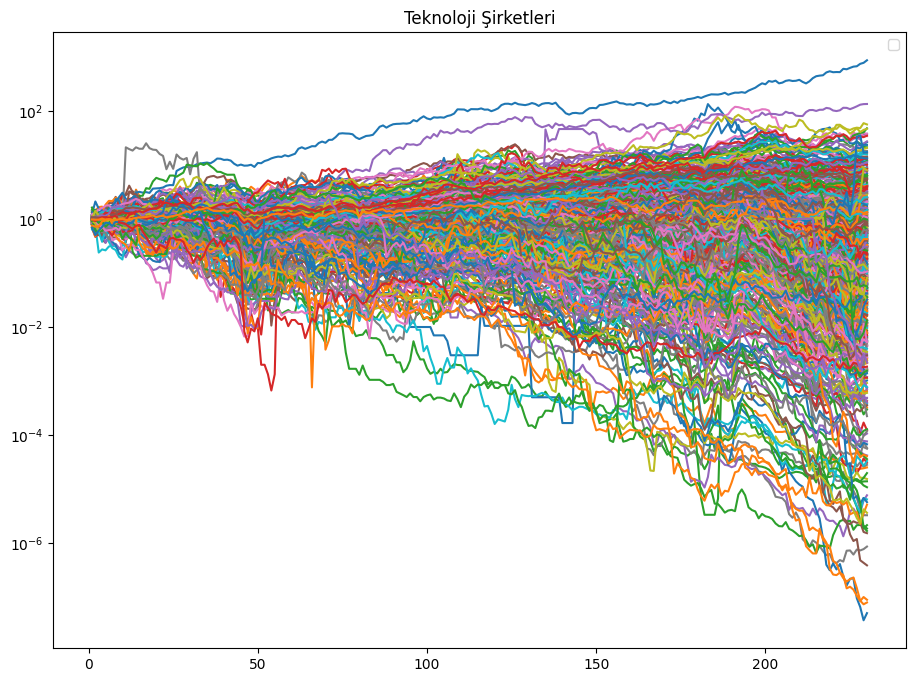

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=[11,8])

for ticker in technology_df.columns:
    if technology_df[ticker].dtype == 'float64' or technology_df[ticker].dtype == 'int64':
        plt.plot(technology_df[ticker].cumprod())

plt.yscale('log')
plt.title('Teknoloji Şirketleri')
plt.legend()
plt.show()

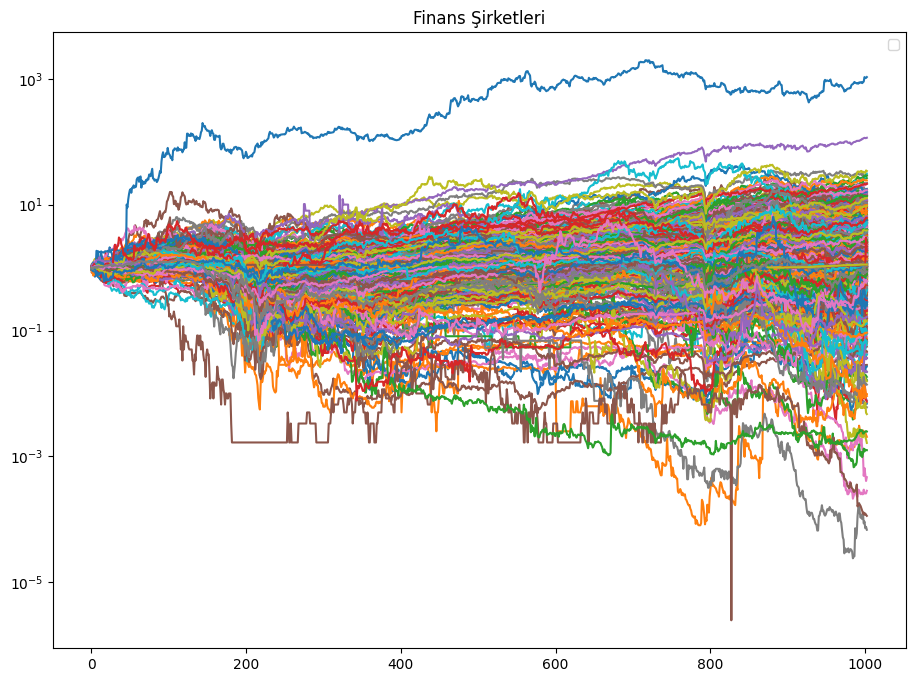

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=[11,8])

for ticker in finance_df.columns:
  if finance_df[ticker].dtype == "float64" or finance_df[ticker].dtype == "int64":
    plt.plot(finance_df[ticker].cumprod())

plt.yscale('log')
plt.title('Finans Şirketleri')
plt.legend()
plt.show()

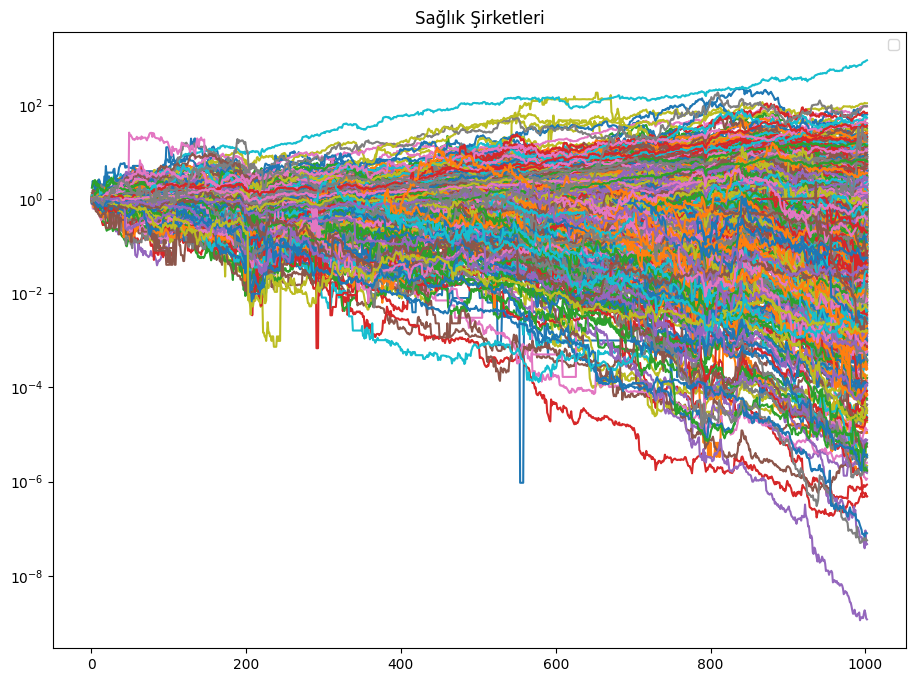

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=[11,8])

for ticker in healthcare_df.columns:
  if healthcare_df[ticker].dtype == "float64" or healthcare_df[ticker].dtype == "int64":
    plt.plot(healthcare_df[ticker].cumprod())

plt.yscale('log')
plt.title('Sağlık Şirketleri')
plt.legend()
plt.show()

# 3.Aşama: Momentum Serileri Üzerinden Feature Engineering Yapılması.

### a) tsfresh ile feature engineering işlemlerini gerçekleştirmek için verilerimizi uygun hale getiriyoruz. Yani sütun değerlerimizi satır satır işliyoruz.

In [ ]:
technology_df.head()

Date  AADI  ABCL      ABIO  ABOS  ABSI  ABVX  ACET      ACHV  ACIU  \
0  2005-01-31   NaN   NaN       NaN   NaN   NaN   NaN   NaN       NaN   NaN   
1  2005-02-28   NaN   NaN  0.983544   NaN   NaN   NaN   NaN  1.047859   NaN   
2  2005-03-31   NaN   NaN  0.836551   NaN   NaN   NaN   NaN  0.634615   NaN   
3  2005-04-30   NaN   NaN  0.896923   NaN   NaN   NaN   NaN  0.969697   NaN   
4  2005-05-31   NaN   NaN  1.272727   NaN   NaN   NaN   NaN  1.285156   NaN   

   ...  YI  YMAB  YS  ZIMV  ZJYL  ZNTL  ZOM  ZURA  ZVSA  ZYME  
0  ... NaN   NaN NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN  
1  ... NaN   NaN NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN  
2  ... NaN   NaN NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN  
3  ... NaN   NaN NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN  
4  ... NaN   NaN NaN   NaN   NaN   NaN  NaN   NaN   NaN   NaN  

[5 rows x 787 columns]

In [ ]:
retech = pd.melt(technology_df, id_vars=["Date"], value_vars=list(technology_df.columns), var_name="Ticker", value_name="Value")
retech

Date Ticker     Value
0       2005-01-31   AADI       NaN
1       2005-02-28   AADI       NaN
2       2005-03-31   AADI       NaN
3       2005-04-30   AADI       NaN
4       2005-05-31   AADI       NaN
...            ...    ...       ...
181561  2023-11-30   ZYME  1.263533
181562  2023-12-31   ZYME  1.171364
181563  2024-01-31   ZYME  1.043311
181564  2024-02-29   ZYME  1.107934
181565  2024-03-31   ZYME  0.895920

[181566 rows x 3 columns]

In [ ]:
rehealth = pd.melt(healthcare_df, id_vars=["Date"], value_vars=list(healthcare_df.columns), var_name = "Ticker", value_name = "Value")
rehealth

Date Ticker     Value
0        2005-01-03      A       NaN
1        2005-01-10      A  0.946398
2        2005-01-17      A  0.975664
3        2005-01-24      A  0.972335
4        2005-01-31      A  1.031250
...             ...    ...       ...
1221649  2024-02-19   ZYXI  1.006334
1221650  2024-02-26   ZYXI  1.008655
1221651  2024-03-04   ZYXI  0.980499
1221652  2024-03-11   ZYXI  1.009547
1221653  2024-03-18   ZYXI  1.001576

[1221654 rows x 3 columns]

In [ ]:
refinance = pd.melt(finance_df, id_vars=["Date"], value_vars=list(finance_df.columns), var_name = "Ticker", value_name= "Value")
refinance

Date Ticker     Value
0        2005-01-03   AACI       NaN
1        2005-01-10   AACI       NaN
2        2005-01-17   AACI       NaN
3        2005-01-24   AACI       NaN
4        2005-01-31   AACI       NaN
...             ...    ...       ...
1001992  2024-02-19    ZLS  0.997214
1001993  2024-02-26    ZLS  1.000931
1001994  2024-03-04    ZLS  1.001861
1001995  2024-03-11    ZLS  1.002785
1001996  2024-03-18    ZLS  1.000000

[1001997 rows x 3 columns]

### b) feature extraction yapmadan önce nan değerlerini silmemiz gerekecek bu yüzden nan değerleri siliyoruz.

In [ ]:
retech.dropna(inplace=True)
rehealth.dropna(inplace=True)
refinance.dropna(inplace=True)

In [ ]:
retech

Date Ticker     Value
158     2018-03-31   AADI  0.969388
159     2018-04-30   AADI  0.747368
160     2018-05-31   AADI  1.098592
161     2018-06-30   AADI  1.064103
162     2018-07-31   AADI  0.946988
...            ...    ...       ...
181561  2023-11-30   ZYME  1.263533
181562  2023-12-31   ZYME  1.171364
181563  2024-01-31   ZYME  1.043311
181564  2024-02-29   ZYME  1.107934
181565  2024-03-31   ZYME  0.895920

[83487 rows x 3 columns]

In [ ]:
rehealth

Date Ticker     Value
1        2005-01-10      A  0.946398
2        2005-01-17      A  0.975664
3        2005-01-24      A  0.972335
4        2005-01-31      A  1.031250
5        2005-02-07      A  1.045680
...             ...    ...       ...
1221649  2024-02-19   ZYXI  1.006334
1221650  2024-02-26   ZYXI  1.008655
1221651  2024-03-04   ZYXI  0.980499
1221652  2024-03-11   ZYXI  1.009547
1221653  2024-03-18   ZYXI  1.001576

[566565 rows x 3 columns]

In [ ]:
refinance

Date Ticker     Value
881      2021-11-22   AACI  1.001021
882      2021-11-29   AACI  0.998469
883      2021-12-06   AACI  0.998467
884      2021-12-13   AACI  0.997953
885      2021-12-20   AACI  1.005128
...             ...    ...       ...
1001992  2024-02-19    ZLS  0.997214
1001993  2024-02-26    ZLS  1.000931
1001994  2024-03-04    ZLS  1.001861
1001995  2024-03-11    ZLS  1.002785
1001996  2024-03-18    ZLS  1.000000

[575253 rows x 3 columns]

## 1) Feature Extraction

In [ ]:
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 8.4 MB/s eta 0:00:00


In [ ]:
import tsfresh
retech_ex = tsfresh.extract_features(retech, column_id="Ticker",column_sort="Date", column_value="Value",default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())
retech_ex

Feature Extraction: 100%|██████████| 785/785 [01:21<00:00,  9.65it/s]


Value__variance_larger_than_standard_deviation  \
AADI                                             0.0   
ABCL                                             0.0   
ABIO                                             0.0   
ABOS                                             0.0   
ABSI                                             0.0   
...                                              ...   
ZNTL                                             0.0   
ZOM                                              0.0   
ZURA                                             0.0   
ZVSA                                             0.0   
ZYME                                             0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
AADI                       0.0                       0.0   
ABCL                       0.0                       0.0   
ABIO                       0.0                       0.0   
ABOS                       0.0                       0.0   
ABSI                       0.0                       0.0   
...                        ...                       ...   
ZNTL                       0.0                       0.0   
ZOM                        0.0                       0.0   
ZURA                       0.0                       0.0   
ZVSA                       0.0                       0.0   
ZYME                       0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
AADI                   0.0          71.862777          75.207139   
ABCL                   0.0          37.556954          37.348964   
ABIO                   1.0         226.013347         239.473686   
ABOS                   0.0          32.127230          35.105982   
ABSI                   0.0          31.938849          36.302070   
...                    ...                ...                ...   
ZNTL                   0.0          47.088032          49.029966   
ZOM                    1.0          77.458940          93.763351   
ZURA                   0.0          11.028437          10.951071   
ZVSA                   0.0          21.663083          21.606694   
ZYME                   0.0          84.116630          87.979525   

      Value__mean_abs_change  Value__mean_change  \
AADI                0.272613            0.001377   
ABCL                0.215981           -0.009067   
ABIO                0.232413            0.000099   
ABOS                0.361140           -0.005197   
ABSI                0.385671            0.009643   
...                      ...                 ...   
ZNTL                0.231482           -0.010589   
ZOM                 0.323780            0.001590   
ZURA                0.353787            0.038793   
ZVSA                0.307542           -0.012311   
ZYME                0.196297           -0.000078   

      Value__mean_second_derivative_central  Value__median  ...  \
AADI                               0.001549       0.969388  ...   
ABCL                               0.007826       0.952260  ...   
ABIO                               0.000253       0.980244  ...   
ABOS                              -0.000507       0.950722  ...   
ABSI                              -0.005076       0.904634  ...   
...                                     ...            ...  ...   
ZNTL                               0.003451       0.994384  ...   
ZOM                               -0.002358       0.946552  ...   
ZURA                              -0.038992       0.921227  ...   
ZVSA                              -0.026263       0.915493  ...   
ZYME                              -0.000133       1.007831  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
AADI                        1.266719                         1.944823   
ABCL                        1.501327                         2.055845   
ABIO                        1.187330                         1.857630   
ABOS                        1.232405                         1.676696   


In [ ]:
retech_ex.describe()

Value__variance_larger_than_standard_deviation  \
count                                      785.000000   
mean                                         0.015287   
std                                          0.122769   
min                                          0.000000   
25%                                          0.000000   
50%                                          0.000000   
75%                                          0.000000   
max                                          1.000000   

       Value__has_duplicate_max  Value__has_duplicate_min  \
count                     785.0                     785.0   
mean                        0.0                       0.0   
std                         0.0                       0.0   
min                         0.0                       0.0   
25%                         0.0                       0.0   
50%                         0.0                       0.0   
75%                         0.0                       0.0   
max                         0.0                       0.0   

       Value__has_duplicate  Value__sum_values  Value__abs_energy  \
count            785.000000         785.000000         785.000000   
mean               0.257325         109.189149        1245.752611   
std                0.437439          89.059996       26671.478596   
min                0.000000           0.763889           0.583526   
25%                0.000000          37.305824          40.701789   
50%                0.000000          77.960716          87.120196   
75%                1.000000         193.752906         210.764804   
max                1.000000        1101.116549      738237.716732   

       Value__mean_abs_change  Value__mean_change  \
count              779.000000          779.000000   
mean                 0.270769            0.000143   
std                  0.337222            0.023184   
min                  0.040713           -0.324303   
25%                  0.183118           -0.001877   
50%                  0.244394           -0.000053   
75%                  0.301283            0.001485   
max                  7.879710            0.311058   

       Value__mean_second_derivative_central  Value__median  ...  \
count                             776.000000     785.000000  ...   
mean                               -0.000419       0.972391  ...   
std                                 0.020757       0.046454  ...   
min                                -0.201719       0.750356  ...   
25%                                -0.002737       0.947926  ...   
50%                                -0.000211       0.982456  ...   
75%                                 0.000691       1.001541  ...   
max                                 0.378458       1.361842  ...   

       Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
count                      779.000000                       779.000000   
mean                         1.166711                         1.727272   
std                          0.241652                         0.285158   
min                         -0.000000                        -0.000000   
25%                          1.031314                         1.603227   
50%                          1.195879                         1.772882   
75%                          1.336108                         1.908665   
max                          1.598369                         2.200663   

       Value__fourier_entropy__bins_100  \
count                        779.000000   
mean                           3.119924   
std                            0.559796   
min                           -0.000000   
25%                            2.798513   
50%                            3.245232   
75%                            3.543849   
max                            3.953371   

       Value__permutation_entropy__dimension_3__tau_1  \
count                                      776.000000   
mean                                         1.745343   
std 

In [ ]:
refinance_ex = tsfresh.extract_features(refinance, column_id="Ticker",column_sort="Date", column_value="Value",default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())
refinance_ex

Feature Extraction: 100%|██████████| 990/990 [10:47<00:00,  1.53it/s]


Value__variance_larger_than_standard_deviation  \
AACI                                             0.0   
AACT                                             0.0   
AAMC                                             0.0   
AAME                                             0.0   
AB                                               0.0   
...                                              ...   
XYF                                              0.0   
YOTA                                             0.0   
YRD                                              0.0   
ZION                                             0.0   
ZLS                                              0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
AACI                       0.0                       0.0   
AACT                       0.0                       0.0   
AAMC                       0.0                       0.0   
AAME                       0.0                       0.0   
AB                         0.0                       0.0   
...                        ...                       ...   
XYF                        0.0                       0.0   
YOTA                       0.0                       0.0   
YRD                        0.0                       0.0   
ZION                       0.0                       0.0   
ZLS                        0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
AACI                   1.0         122.117864         122.240232   
AACT                   1.0          39.042668          39.085451   
AAMC                   0.0         104.757971         108.881337   
AAME                   1.0        1005.226672        1016.600409   
AB                     1.0        1004.699790        1010.363564   
...                    ...                ...                ...   
XYF                    1.0         286.587745         292.369724   
YOTA                   1.0          90.114533          90.233236   
YRD                    1.0         432.386037         441.187044   
ZION                   0.0        1004.106506        1010.727470   
ZLS                    1.0         129.112790         129.228057   

      Value__mean_abs_change  Value__mean_change  \
AACI                0.005360       -9.149268e-07   
AACT                0.001569       -6.536215e-05   
AAMC                0.168299       -4.254879e-05   
AAME                0.077157       -3.431515e-05   
AB                  0.050733        5.061569e-05   
...                      ...                 ...   
XYF                 0.129299        1.194295e-05   
YOTA                0.006605        2.285997e-05   
YRD                 0.119663       -5.092922e-05   
ZION                0.063764        1.949941e-05   
ZLS                 0.004599       -6.469973e-05   

      Value__mean_second_derivative_central  Value__median  ...  \
AACI                               0.000014       1.000300  ...   
AACT                               0.000020       1.000980  ...   
AAMC                               0.000074       0.993642  ...   
AAME                               0.000041       1.000000  ...   
AB                                -0.000036       1.003636  ...   
...                                     ...            ...  ...   
XYF                               -0.000033       0.989470  ...   
YOTA                              -0.000035       1.000963  ...   
YRD                                0.000332       0.987771  ...   
ZION                              -0.000045       1.001098  ...   
ZLS                                0.000050       1.000965  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
AACI                        1.168466                         1.804009   
AACT                        1.544480                         1.999164   
AAMC                        0.839094                         1.429477   
AAME                        1.013333                         1.643690   


In [ ]:
refinance_ex.describe()

Value__variance_larger_than_standard_deviation  \
count                                      990.000000   
mean                                         0.002020   
std                                          0.044924   
min                                          0.000000   
25%                                          0.000000   
50%                                          0.000000   
75%                                          0.000000   
max                                          1.000000   

       Value__has_duplicate_max  Value__has_duplicate_min  \
count                     990.0                990.000000   
mean                        0.0                  0.001010   
std                         0.0                  0.031782   
min                         0.0                  0.000000   
25%                         0.0                  0.000000   
50%                         0.0                  0.000000   
75%                         0.0                  0.000000   
max                         0.0                  1.000000   

       Value__has_duplicate  Value__sum_values  Value__abs_energy  \
count            990.000000         990.000000       9.900000e+02   
mean               0.875758         586.045318       7.405066e+03   
std                0.330025         413.189832       1.779182e+05   
min                0.000000           1.000120       1.000239e+00   
25%                1.000000         134.416152       1.355300e+02   
50%                1.000000         608.815408       6.133712e+02   
75%                1.000000        1003.831429       1.007925e+03   
max                1.000000        3295.288926       5.445573e+06   

       Value__mean_abs_change  Value__mean_change  \
count              989.000000          989.000000   
mean                 0.057045           -0.000088   
std                  0.206133            0.002463   
min                  0.001262           -0.067045   
25%                  0.030325           -0.000040   
50%                  0.045039            0.000006   
75%                  0.057118            0.000043   
max                  5.339761            0.010036   

       Value__mean_second_derivative_central  Value__median  ...  \
count                             989.000000     990.000000  ...   
mean                               -0.000044       1.000251  ...   
std                                 0.001953       0.005706  ...   
min                                -0.047990       0.906416  ...   
25%                                -0.000040       1.000000  ...   
50%                                -0.000013       1.000907  ...   
75%                                 0.000014       1.001826  ...   
max                                 0.023076       1.026838  ...   

       Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
count                      989.000000                       989.000000   
mean                         1.165935                         1.777994   
std                          0.220771                         0.260582   
min                          0.090729                         0.090729   
25%                          1.055315                         1.663416   
50%                          1.210950                         1.829600   
75%                          1.322507                         1.950812   
max                          1.600591                         2.263094   

       Value__fourier_entropy__bins_100  \
count                        989.000000   
mean                           3.596863   
std                            0.435754   
min                            0.136002   
25%                            3.445955   
50%                            3.731949   
75%                            3.872192   
max                            4.103432   

       Value__permutation_entropy__dimension_3__tau_1  \
count                                      989.000000   
mean                                         1.773461   
std 

In [ ]:
rehealth_ex = tsfresh.extract_features(rehealth, column_id="Ticker",column_sort="Date", column_value="Value",default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())
rehealth_ex

Feature Extraction: 100%|██████████| 1217/1217 [09:19<00:00,  2.18it/s]


Value__variance_larger_than_standard_deviation  \
A                                                0.0   
AADI                                             0.0   
ABBV                                             0.0   
ABCL                                             0.0   
ABEO                                             0.0   
...                                              ...   
ZURA                                             0.0   
ZVRA                                             0.0   
ZVSA                                             0.0   
ZYME                                             0.0   
ZYXI                                             0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
A                          0.0                       0.0   
AADI                       0.0                       0.0   
ABBV                       0.0                       0.0   
ABCL                       0.0                       0.0   
ABEO                       0.0                       0.0   
...                        ...                       ...   
ZURA                       0.0                       0.0   
ZVRA                       0.0                       0.0   
ZVSA                       0.0                       0.0   
ZYME                       0.0                       0.0   
ZYXI                       0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
A                      1.0        1005.209759        1010.187698   
AADI                   1.0         315.903408         319.161688   
ABBV                   0.0         586.517624         589.849955   
ABCL                   0.0         168.540470         168.778384   
ABEO                   1.0        1005.068162        1035.831649   
...                    ...                ...                ...   
ZURA                   1.0          49.744230          49.251104   
ZVRA                   1.0         465.063550         472.004570   
ZVSA                   1.0         106.578818         109.844990   
ZYME                   1.0         360.311950         364.648335   
ZYXI                   1.0        1014.181574        1042.670512   

      Value__mean_abs_change  Value__mean_change  \
A                   0.043765            0.000059   
AADI                0.118130           -0.000335   
ABBV                0.037821            0.000007   
ABCL                0.102465            0.000484   
ABEO                0.146971            0.000090   
...                      ...                 ...   
ZURA                0.121219            0.003259   
ZVRA                0.122166            0.000102   
ZVSA                0.187081           -0.000906   
ZYME                0.099650           -0.000065   
ZYXI                0.131982            0.000135   

      Value__mean_second_derivative_central  Value__median  ...  \
A                                 -0.000027       1.003145  ...   
AADI                               0.000363       0.986842  ...   
ABBV                              -0.000088       1.004815  ...   
ABCL                               0.000019       0.986677  ...   
ABEO                               0.000016       0.986966  ...   
...                                     ...            ...  ...   
ZURA                               0.000971       0.964183  ...   
ZVRA                               0.000019       0.993056  ...   
ZVSA                               0.000029       0.998002  ...   
ZYME                               0.000114       0.998066  ...   
ZYXI                              -0.000128       1.000000  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
A                           1.274529                         1.889444   
AADI                        0.846540                         1.463154   
ABBV                        1.258641                         1.902511   
ABCL                        0.902830                         1.501084   


In [ ]:
rehealth_ex.describe()

Value__variance_larger_than_standard_deviation  \
count                                     1217.000000   
mean                                         0.009039   
std                                          0.094680   
min                                          0.000000   
25%                                          0.000000   
50%                                          0.000000   
75%                                          0.000000   
max                                          1.000000   

       Value__has_duplicate_max  Value__has_duplicate_min  \
count               1217.000000               1217.000000   
mean                   0.000822                  0.001643   
std                    0.028665                  0.040522   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    0.000000                  0.000000   
75%                    0.000000                  0.000000   
max                    1.000000                  1.000000   

       Value__has_duplicate  Value__sum_values  Value__abs_energy  \
count           1217.000000        1217.000000       1.217000e+03   
mean               0.736237         471.684476       1.541442e+04   
std                0.440854         370.572535       4.981518e+05   
min                0.000000           3.753263       3.578666e+00   
25%                0.000000         168.232226       1.722336e+02   
50%                1.000000         339.920856       3.563715e+02   
75%                1.000000         843.740777       8.942456e+02   
max                1.000000        5206.220431       1.736251e+07   

       Value__mean_abs_change  Value__mean_change  \
count             1217.000000         1217.000000   
mean                 0.130247            0.000239   
std                  0.253044            0.006427   
min                  0.018213           -0.107525   
25%                  0.092840           -0.000168   
50%                  0.118643            0.000012   
75%                  0.145197            0.000212   
max                  8.562558            0.135503   

       Value__mean_second_derivative_central  Value__median  ...  \
count                            1217.000000    1217.000000  ...   
mean                               -0.000232       0.993012  ...   
std                                 0.009640       0.012180  ...   
min                                -0.243978       0.873831  ...   
25%                                -0.000141       0.988143  ...   
50%                                -0.000002       0.995907  ...   
75%                                 0.000155       1.000000  ...   
max                                 0.114755       1.037330  ...   

       Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
count                     1217.000000                      1217.000000   
mean                         1.176338                         1.799922   
std                          0.210770                         0.251023   
min                          0.090729                         0.090729   
25%                          1.066984                         1.694487   
50%                          1.216760                         1.845224   
75%                          1.328608                         1.963764   
max                          1.601044                         2.258595   

       Value__fourier_entropy__bins_100  \
count                       1217.000000   
mean                           3.649336   
std                            0.418013   
min                            0.273489   
25%                            3.539363   
50%                            3.748037   
75%                            3.883163   
max                            4.188729   

       Value__permutation_entropy__dimension_3__tau_1  \
count                                     1217.000000   
mean                                         1.775068   
std 

### a) Feature extraction yaptıktan sonra dataframelerimi kaydetmek istiyorum tekrardan sonraki çalışmamda vakit kaybetmemek için

In [ ]:
rehealth_ex.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/rehealth_ex.csv")
refinance_ex.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/refinance_ex.csv")
retech_ex.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/retech_ex.csv")

**Vakit kaybetmemek için buradan sonrasını çalıştırabilirsiniz**

In [4]:
rehealth_ex = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/rehealth_ex.csv")
refinance_ex = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/refinance_ex.csv")
retech_ex = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/retech_ex.csv")

### b) Finans Sağlık ve teknoloji sektörlerindeki dataframe'lere label ataması gerçekleştireceğim
sağlık için label sütunu ---> h  
finans için label sütunu ---> f  
technology için label sütunu ---> t  


In [5]:
rehealth_ex["label"] = "h"
refinance_ex["label"] = "f"
retech_ex["label"] = "t"
rehealth_ex.head()

Unnamed: 0.1 Unnamed: 0  Value__variance_larger_than_standard_deviation  \
0             0          A                                             0.0   
1             1       AADI                                             0.0   
2             2       ABBV                                             0.0   
3             3       ABCL                                             0.0   
4             4       ABEO                                             0.0   

   Value__has_duplicate_max  Value__has_duplicate_min  Value__has_duplicate  \
0                       0.0                       0.0                   1.0   
1                       0.0                       0.0                   1.0   
2                       0.0                       0.0                   0.0   
3                       0.0                       0.0                   0.0   
4                       0.0                       0.0                   1.0   

   Value__sum_values  Value__abs_energy  Value__mean_abs_change  \
0        1005.209759        1010.187698                0.043765   
1         315.903408         319.161688                0.118130   
2         586.517624         589.849955                0.037821   
3         168.540470         168.778384                0.102465   
4        1005.068162        1035.831649                0.146971   

   Value__mean_change  ...  Value__fourier_entropy__bins_10  \
0            0.000059  ...                         1.889444   
1           -0.000335  ...                         1.463154   
2            0.000007  ...                         1.902511   
3            0.000484  ...                         1.501084   
4            0.000090  ...                         1.886987   

   Value__fourier_entropy__bins_100  \
0                          3.848812   
1                          3.519795   
2                          3.909249   
3                          3.390340   
4                          3.860320   

   Value__permutation_entropy__dimension_3__tau_1  \
0                                        1.789997   
1                                        1.782552   
2                                        1.787299   
3                                        1.779653   
4                                        1.789437   

   Value__permutation_entropy__dimension_4__tau_1  \
0                                        3.170507   
1                                        3.151172   
2                                        3.153455   
3                                        3.125994   
4                                        3.169742   

   Value__permutation_entropy__dimension_5__tau_1  \
0                                        4.738476   
1                                        4.618262   
2                                        4.652203   
3                                        4.290890   
4                                        4.740168   

   Value__permutation_entropy__dimension_6__tau_1  \
0                                        6.168883   
1                                        5.519665   
2                                        5.842925   
3                                        4.869584   
4                                        6.187194   

   Value__permutation_entropy__dimension_7__tau_1  \
0                                        6.793947   
1                                        5.706908   
2                                        6.257029   
3                                        5.029052   
4                                        6.798307   

   Value__query_similarity_count__query_None__threshold_0.0  \
0                                                NaN          
1                                                NaN          
2                                                NaN          
3                                                NaN          
4                                                NaN          

   Value__mean_n_absolute_max__number_of_maxima_7  label  
0        

In [ ]:
rehealth_ex.describe()

Unnamed: 0.1  Value__variance_larger_than_standard_deviation  \
count   1217.000000                                     1217.000000   
mean     608.000000                                        0.009039   
std      351.461947                                        0.094680   
min        0.000000                                        0.000000   
25%      304.000000                                        0.000000   
50%      608.000000                                        0.000000   
75%      912.000000                                        0.000000   
max     1216.000000                                        1.000000   

       Value__has_duplicate_max  Value__has_duplicate_min  \
count               1217.000000               1217.000000   
mean                   0.000822                  0.001643   
std                    0.028665                  0.040522   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    0.000000                  0.000000   
75%                    0.000000                  0.000000   
max                    1.000000                  1.000000   

       Value__has_duplicate  Value__sum_values  Value__abs_energy  \
count           1217.000000        1217.000000       1.217000e+03   
mean               0.736237         471.684476       1.541442e+04   
std                0.440854         370.572535       4.981518e+05   
min                0.000000           3.753263       3.578666e+00   
25%                0.000000         168.232226       1.722336e+02   
50%                1.000000         339.920856       3.563715e+02   
75%                1.000000         843.740777       8.942456e+02   
max                1.000000        5206.220431       1.736251e+07   

       Value__mean_abs_change  Value__mean_change  \
count             1217.000000         1217.000000   
mean                 0.130247            0.000239   
std                  0.253044            0.006427   
min                  0.018213           -0.107525   
25%                  0.092840           -0.000168   
50%                  0.118643            0.000012   
75%                  0.145197            0.000212   
max                  8.562558            0.135503   

       Value__mean_second_derivative_central  ...  \
count                            1217.000000  ...   
mean                               -0.000232  ...   
std                                 0.009640  ...   
min                                -0.243978  ...   
25%                                -0.000141  ...   
50%                                -0.000002  ...   
75%                                 0.000155  ...   
max                                 0.114755  ...   

       Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
count                     1217.000000                      1217.000000   
mean                         1.176338                         1.799922   
std                          0.210770                         0.251023   
min                          0.090729                         0.090729   
25%                          1.066984                         1.694487   
50%                          1.216760                         1.845224   
75%                          1.328608                         1.963764   
max                          1.601044                         2.258595   

       Value__fourier_entropy__bins_100  \
count                       1217.000000   
mean                           3.649336   
std                            0.418013   
min                            0.273489   
25%                            3.539363   
50%                            3.748037   
75%                            3.883163   
max                            4.188729   

       Value__permutation_entropy__dimension_3__tau_1  \
count                                     1217.000000   
mean                                         1.775068   
std          

In [ ]:
refinance_ex.describe()

Unnamed: 0.1  Value__variance_larger_than_standard_deviation  \
count    990.000000                                      990.000000   
mean     494.500000                                        0.002020   
std      285.932684                                        0.044924   
min        0.000000                                        0.000000   
25%      247.250000                                        0.000000   
50%      494.500000                                        0.000000   
75%      741.750000                                        0.000000   
max      989.000000                                        1.000000   

       Value__has_duplicate_max  Value__has_duplicate_min  \
count                     990.0                990.000000   
mean                        0.0                  0.001010   
std                         0.0                  0.031782   
min                         0.0                  0.000000   
25%                         0.0                  0.000000   
50%                         0.0                  0.000000   
75%                         0.0                  0.000000   
max                         0.0                  1.000000   

       Value__has_duplicate  Value__sum_values  Value__abs_energy  \
count            990.000000         990.000000       9.900000e+02   
mean               0.875758         586.045318       7.405066e+03   
std                0.330025         413.189832       1.779182e+05   
min                0.000000           1.000120       1.000239e+00   
25%                1.000000         134.416152       1.355300e+02   
50%                1.000000         608.815408       6.133712e+02   
75%                1.000000        1003.831429       1.007925e+03   
max                1.000000        3295.288926       5.445573e+06   

       Value__mean_abs_change  Value__mean_change  \
count              989.000000          989.000000   
mean                 0.057045           -0.000088   
std                  0.206133            0.002463   
min                  0.001262           -0.067045   
25%                  0.030325           -0.000040   
50%                  0.045039            0.000006   
75%                  0.057118            0.000043   
max                  5.339761            0.010036   

       Value__mean_second_derivative_central  ...  \
count                             989.000000  ...   
mean                               -0.000044  ...   
std                                 0.001953  ...   
min                                -0.047990  ...   
25%                                -0.000040  ...   
50%                                -0.000013  ...   
75%                                 0.000014  ...   
max                                 0.023076  ...   

       Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
count                      989.000000                       989.000000   
mean                         1.165935                         1.777994   
std                          0.220771                         0.260582   
min                          0.090729                         0.090729   
25%                          1.055315                         1.663416   
50%                          1.210950                         1.829600   
75%                          1.322507                         1.950812   
max                          1.600591                         2.263094   

       Value__fourier_entropy__bins_100  \
count                        989.000000   
mean                           3.596863   
std                            0.435754   
min                            0.136002   
25%                            3.445955   
50%                            3.731949   
75%                            3.872192   
max                            4.103432   

       Value__permutation_entropy__dimension_3__tau_1  \
count                                      989.000000   
mean                                         1.773461   
std          

In [ ]:
retech_ex.describe()

Unnamed: 0.1  Value__variance_larger_than_standard_deviation  \
count    785.000000                                      785.000000   
mean     392.000000                                        0.015287   
std      226.754272                                        0.122769   
min        0.000000                                        0.000000   
25%      196.000000                                        0.000000   
50%      392.000000                                        0.000000   
75%      588.000000                                        0.000000   
max      784.000000                                        1.000000   

       Value__has_duplicate_max  Value__has_duplicate_min  \
count                     785.0                     785.0   
mean                        0.0                       0.0   
std                         0.0                       0.0   
min                         0.0                       0.0   
25%                         0.0                       0.0   
50%                         0.0                       0.0   
75%                         0.0                       0.0   
max                         0.0                       0.0   

       Value__has_duplicate  Value__sum_values  Value__abs_energy  \
count            785.000000         785.000000         785.000000   
mean               0.257325         109.189149        1245.752611   
std                0.437439          89.059996       26671.478596   
min                0.000000           0.763889           0.583526   
25%                0.000000          37.305824          40.701789   
50%                0.000000          77.960716          87.120196   
75%                1.000000         193.752906         210.764804   
max                1.000000        1101.116549      738237.716732   

       Value__mean_abs_change  Value__mean_change  \
count              779.000000          779.000000   
mean                 0.270769            0.000143   
std                  0.337222            0.023184   
min                  0.040713           -0.324303   
25%                  0.183118           -0.001877   
50%                  0.244394           -0.000053   
75%                  0.301283            0.001485   
max                  7.879710            0.311058   

       Value__mean_second_derivative_central  ...  \
count                             776.000000  ...   
mean                               -0.000419  ...   
std                                 0.020757  ...   
min                                -0.201719  ...   
25%                                -0.002737  ...   
50%                                -0.000211  ...   
75%                                 0.000691  ...   
max                                 0.378458  ...   

       Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
count                      779.000000                       779.000000   
mean                         1.166711                         1.727272   
std                          0.241652                         0.285158   
min                         -0.000000                        -0.000000   
25%                          1.031314                         1.603227   
50%                          1.195879                         1.772882   
75%                          1.336108                         1.908665   
max                          1.598369                         2.200663   

       Value__fourier_entropy__bins_100  \
count                        779.000000   
mean                           3.119924   
std                            0.559796   
min                           -0.000000   
25%                            2.798513   
50%                            3.245232   
75%                            3.543849   
max                            3.953371   

       Value__permutation_entropy__dimension_3__tau_1  \
count                                      776.000000   
mean                                         1.745343   
std          

### c) Feature extraction ile genişlettiğim tüm dataframe'lerimi birleştiriyorum.

In [6]:
concat_df = pd.concat([retech_ex, refinance_ex, rehealth_ex], axis=0)
concat_df

Unnamed: 0.1 Unnamed: 0  Value__variance_larger_than_standard_deviation  \
0                0       AADI                                             0.0   
1                1       ABCL                                             0.0   
2                2       ABIO                                             0.0   
3                3       ABOS                                             0.0   
4                4       ABSI                                             0.0   
...            ...        ...                                             ...   
1212          1212       ZURA                                             0.0   
1213          1213       ZVRA                                             0.0   
1214          1214       ZVSA                                             0.0   
1215          1215       ZYME                                             0.0   
1216          1216       ZYXI                                             0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
1212                       0.0                       0.0   
1213                       0.0                       0.0   
1214                       0.0                       0.0   
1215                       0.0                       0.0   
1216                       0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
0                      0.0          71.862777          75.207139   
1                      0.0          37.556954          37.348964   
2                      1.0         226.013347         239.473686   
3                      0.0          32.127230          35.105982   
4                      0.0          31.938849          36.302070   
...                    ...                ...                ...   
1212                   1.0          49.744230          49.251104   
1213                   1.0         465.063550         472.004570   
1214                   1.0         106.578818         109.844990   
1215                   1.0         360.311950         364.648335   
1216                   1.0        1014.181574        1042.670512   

      Value__mean_abs_change  Value__mean_change  ...  \
0                   0.272613            0.001377  ...   
1                   0.215981           -0.009067  ...   
2                   0.232413            0.000099  ...   
3                   0.361140           -0.005197  ...   
4                   0.385671            0.009643  ...   
...                      ...                 ...  ...   
1212                0.121219            0.003259  ...   
1213                0.122166            0.000102  ...   
1214                0.187081           -0.000906  ...   
1215                0.099650           -0.000065  ...   
1216                0.131982            0.000135  ...   

      Value__fourier_entropy__bins_10  Value__fourier_entropy__bins_100  \
0                            1.944823                          3.334504   
1                            2.055845                          2.718473   
2                            1.857630                          3.746480   
3                            1.676696                          2.588573   
4                            1.674990                          2.639341   
...                               ...                               ...   
1212                         1.797316                          3.151459   
1213                         1.845340                          3.826797   
1214                         1.583626                          3.233202   
1215                         1.410712                       

id'lerini sıfırlıyorum

In [7]:
concat_df.reset_index(drop=True, inplace=True)
concat_df

Unnamed: 0.1 Unnamed: 0  Value__variance_larger_than_standard_deviation  \
0                0       AADI                                             0.0   
1                1       ABCL                                             0.0   
2                2       ABIO                                             0.0   
3                3       ABOS                                             0.0   
4                4       ABSI                                             0.0   
...            ...        ...                                             ...   
2987          1212       ZURA                                             0.0   
2988          1213       ZVRA                                             0.0   
2989          1214       ZVSA                                             0.0   
2990          1215       ZYME                                             0.0   
2991          1216       ZYXI                                             0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
2987                       0.0                       0.0   
2988                       0.0                       0.0   
2989                       0.0                       0.0   
2990                       0.0                       0.0   
2991                       0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
0                      0.0          71.862777          75.207139   
1                      0.0          37.556954          37.348964   
2                      1.0         226.013347         239.473686   
3                      0.0          32.127230          35.105982   
4                      0.0          31.938849          36.302070   
...                    ...                ...                ...   
2987                   1.0          49.744230          49.251104   
2988                   1.0         465.063550         472.004570   
2989                   1.0         106.578818         109.844990   
2990                   1.0         360.311950         364.648335   
2991                   1.0        1014.181574        1042.670512   

      Value__mean_abs_change  Value__mean_change  ...  \
0                   0.272613            0.001377  ...   
1                   0.215981           -0.009067  ...   
2                   0.232413            0.000099  ...   
3                   0.361140           -0.005197  ...   
4                   0.385671            0.009643  ...   
...                      ...                 ...  ...   
2987                0.121219            0.003259  ...   
2988                0.122166            0.000102  ...   
2989                0.187081           -0.000906  ...   
2990                0.099650           -0.000065  ...   
2991                0.131982            0.000135  ...   

      Value__fourier_entropy__bins_10  Value__fourier_entropy__bins_100  \
0                            1.944823                          3.334504   
1                            2.055845                          2.718473   
2                            1.857630                          3.746480   
3                            1.676696                          2.588573   
4                            1.674990                          2.639341   
...                               ...                               ...   
2987                         1.797316                          3.151459   
2988                         1.845340                          3.826797   
2989                         1.583626                          3.233202   
2990                         1.410712                       

### d) Sütundaki bütün değerleri nan olan sütunu siliyorum. Çünkü bu sutuna herhangi bir feature_extraction uygulayamayız.

In [8]:
concat_df.dropna(how="all",axis=1,inplace=True)
concat_df

Unnamed: 0.1 Unnamed: 0  Value__variance_larger_than_standard_deviation  \
0                0       AADI                                             0.0   
1                1       ABCL                                             0.0   
2                2       ABIO                                             0.0   
3                3       ABOS                                             0.0   
4                4       ABSI                                             0.0   
...            ...        ...                                             ...   
2987          1212       ZURA                                             0.0   
2988          1213       ZVRA                                             0.0   
2989          1214       ZVSA                                             0.0   
2990          1215       ZYME                                             0.0   
2991          1216       ZYXI                                             0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
2987                       0.0                       0.0   
2988                       0.0                       0.0   
2989                       0.0                       0.0   
2990                       0.0                       0.0   
2991                       0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
0                      0.0          71.862777          75.207139   
1                      0.0          37.556954          37.348964   
2                      1.0         226.013347         239.473686   
3                      0.0          32.127230          35.105982   
4                      0.0          31.938849          36.302070   
...                    ...                ...                ...   
2987                   1.0          49.744230          49.251104   
2988                   1.0         465.063550         472.004570   
2989                   1.0         106.578818         109.844990   
2990                   1.0         360.311950         364.648335   
2991                   1.0        1014.181574        1042.670512   

      Value__mean_abs_change  Value__mean_change  ...  \
0                   0.272613            0.001377  ...   
1                   0.215981           -0.009067  ...   
2                   0.232413            0.000099  ...   
3                   0.361140           -0.005197  ...   
4                   0.385671            0.009643  ...   
...                      ...                 ...  ...   
2987                0.121219            0.003259  ...   
2988                0.122166            0.000102  ...   
2989                0.187081           -0.000906  ...   
2990                0.099650           -0.000065  ...   
2991                0.131982            0.000135  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
0                           1.266719                         1.944823   
1                           1.501327                         2.055845   
2                           1.187330                         1.857630   
3                           1.232405                         1.676696   
4                           1.203332                         1.674990   
...                              ...                              ...   
2987                        1.262152                         1.797316   
2988                        1.161260                         1.845340   
2989                        1.072125                         1.583626   
2990                        0.795175                         1.410712   
2991   

In [9]:
concat_df.drop("Unnamed: 0.1",axis=1,inplace=True)
concat_df

Unnamed: 0  Value__variance_larger_than_standard_deviation  \
0          AADI                                             0.0   
1          ABCL                                             0.0   
2          ABIO                                             0.0   
3          ABOS                                             0.0   
4          ABSI                                             0.0   
...         ...                                             ...   
2987       ZURA                                             0.0   
2988       ZVRA                                             0.0   
2989       ZVSA                                             0.0   
2990       ZYME                                             0.0   
2991       ZYXI                                             0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
2987                       0.0                       0.0   
2988                       0.0                       0.0   
2989                       0.0                       0.0   
2990                       0.0                       0.0   
2991                       0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
0                      0.0          71.862777          75.207139   
1                      0.0          37.556954          37.348964   
2                      1.0         226.013347         239.473686   
3                      0.0          32.127230          35.105982   
4                      0.0          31.938849          36.302070   
...                    ...                ...                ...   
2987                   1.0          49.744230          49.251104   
2988                   1.0         465.063550         472.004570   
2989                   1.0         106.578818         109.844990   
2990                   1.0         360.311950         364.648335   
2991                   1.0        1014.181574        1042.670512   

      Value__mean_abs_change  Value__mean_change  \
0                   0.272613            0.001377   
1                   0.215981           -0.009067   
2                   0.232413            0.000099   
3                   0.361140           -0.005197   
4                   0.385671            0.009643   
...                      ...                 ...   
2987                0.121219            0.003259   
2988                0.122166            0.000102   
2989                0.187081           -0.000906   
2990                0.099650           -0.000065   
2991                0.131982            0.000135   

      Value__mean_second_derivative_central  ...  \
0                                  0.001549  ...   
1                                  0.007826  ...   
2                                  0.000253  ...   
3                                 -0.000507  ...   
4                                 -0.005076  ...   
...                                     ...  ...   
2987                               0.000971  ...   
2988                               0.000019  ...   
2989                               0.000029  ...   
2990                               0.000114  ...   
2991                              -0.000128  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
0                           1.266719                         1.944823   
1                           1.501327                         2.055845   
2                           1.187330                         1.857630   
3                           1.232405                         1.676696   
4                           1.203332           

In [10]:
sayisal_degiskenler = concat_df.select_dtypes(include=[np.float64, np.int64]).columns

In [11]:
concat_df.isna().sum()

Unnamed: 0                                         0
Value__variance_larger_than_standard_deviation     0
Value__has_duplicate_max                           0
Value__has_duplicate_min                           0
Value__has_duplicate                               0
                                                  ..
Value__permutation_entropy__dimension_5__tau_1    16
Value__permutation_entropy__dimension_6__tau_1    22
Value__permutation_entropy__dimension_7__tau_1    28
Value__mean_n_absolute_max__number_of_maxima_7    33
label                                              0
Length: 784, dtype: int64

In [12]:
concat_df

Unnamed: 0  Value__variance_larger_than_standard_deviation  \
0          AADI                                             0.0   
1          ABCL                                             0.0   
2          ABIO                                             0.0   
3          ABOS                                             0.0   
4          ABSI                                             0.0   
...         ...                                             ...   
2987       ZURA                                             0.0   
2988       ZVRA                                             0.0   
2989       ZVSA                                             0.0   
2990       ZYME                                             0.0   
2991       ZYXI                                             0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
2987                       0.0                       0.0   
2988                       0.0                       0.0   
2989                       0.0                       0.0   
2990                       0.0                       0.0   
2991                       0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
0                      0.0          71.862777          75.207139   
1                      0.0          37.556954          37.348964   
2                      1.0         226.013347         239.473686   
3                      0.0          32.127230          35.105982   
4                      0.0          31.938849          36.302070   
...                    ...                ...                ...   
2987                   1.0          49.744230          49.251104   
2988                   1.0         465.063550         472.004570   
2989                   1.0         106.578818         109.844990   
2990                   1.0         360.311950         364.648335   
2991                   1.0        1014.181574        1042.670512   

      Value__mean_abs_change  Value__mean_change  \
0                   0.272613            0.001377   
1                   0.215981           -0.009067   
2                   0.232413            0.000099   
3                   0.361140           -0.005197   
4                   0.385671            0.009643   
...                      ...                 ...   
2987                0.121219            0.003259   
2988                0.122166            0.000102   
2989                0.187081           -0.000906   
2990                0.099650           -0.000065   
2991                0.131982            0.000135   

      Value__mean_second_derivative_central  ...  \
0                                  0.001549  ...   
1                                  0.007826  ...   
2                                  0.000253  ...   
3                                 -0.000507  ...   
4                                 -0.005076  ...   
...                                     ...  ...   
2987                               0.000971  ...   
2988                               0.000019  ...   
2989                               0.000029  ...   
2990                               0.000114  ...   
2991                              -0.000128  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
0                           1.266719                         1.944823   
1                           1.501327                         2.055845   
2                           1.187330                         1.857630   
3                           1.232405                         1.676696   
4                           1.203332           

## 2) Feature Imputing

In [13]:
concat_df.isna().sum()

Unnamed: 0                                         0
Value__variance_larger_than_standard_deviation     0
Value__has_duplicate_max                           0
Value__has_duplicate_min                           0
Value__has_duplicate                               0
                                                  ..
Value__permutation_entropy__dimension_5__tau_1    16
Value__permutation_entropy__dimension_6__tau_1    22
Value__permutation_entropy__dimension_7__tau_1    28
Value__mean_n_absolute_max__number_of_maxima_7    33
label                                              0
Length: 784, dtype: int64

### a) Yukarıda görüldüğü üzere bazı sütunlarımda nan değer bulunmakta bu değerleri kendi label'ları çerçevesinde ortalama değerleriyle dolduracağım. Bunun için feature_engine kütüphanesini kullanacağım

In [14]:
!pip install feature_engine

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 6.1 MB/s eta 0:00:00


1. dataframe'imdeki sayısal değişkenleri buluyorum.
2. dataframe'imdeki labellarıma göre nan olan değerleri ortalama ile dolduruyorum

In [15]:
from feature_engine.imputation import MeanMedianImputer
sayisal_degiskenler = concat_df.select_dtypes(include=[np.float64, np.int64]).columns
ImputerEngine = MeanMedianImputer(imputation_method="mean",variables=sayisal_degiskenler.to_list())
for label in ["t", "f", "h"]:
  concat_df.loc[concat_df["label"] == label, sayisal_degiskenler] = ImputerEngine.fit_transform(concat_df[concat_df["label"] == label][sayisal_degiskenler])

In [16]:
concat_df.isna().sum()

Unnamed: 0                                        0
Value__variance_larger_than_standard_deviation    0
Value__has_duplicate_max                          0
Value__has_duplicate_min                          0
Value__has_duplicate                              0
                                                 ..
Value__permutation_entropy__dimension_5__tau_1    0
Value__permutation_entropy__dimension_6__tau_1    0
Value__permutation_entropy__dimension_7__tau_1    0
Value__mean_n_absolute_max__number_of_maxima_7    0
label                                             0
Length: 784, dtype: int64

sonsuz olan degerleri 0 ile degistirdik

In [17]:
concat_df.replace([np.inf, -np.inf], 0, inplace=True)

model eğitiminde işimize yaramayacak sütunu drop ettik

In [29]:
concat_df.drop("Unnamed: 0", axis=1, inplace=True)

### b) Aşağıda görüldüğü üzere imbalanced classification problemini çözmek istiyorum

<Axes: xlabel='Siniflar', ylabel='Miktar'>

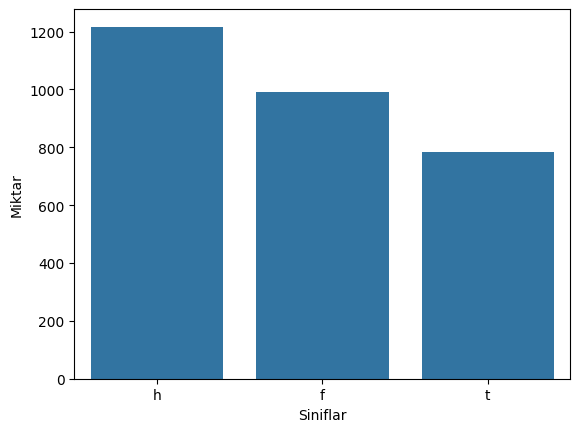

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
df_graph = pd.DataFrame({
    "Siniflar" : concat_df["label"].value_counts().index,
    "Miktar": concat_df["label"].value_counts().values
})
fig, ax = plt.subplots()
sns.barplot(data=df_graph, x="Siniflar", y="Miktar")

In [33]:
from imblearn.over_sampling import RandomOverSampler

X = concat_df.drop(["label"], axis=1)
y = concat_df["label"]

sampler = RandomOverSampler()
X_resampled, y_resampled = sampler.fit_resample(X, y)

concat_df = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=["label"])], axis=1)

<Axes: xlabel='Siniflar', ylabel='Miktar'>

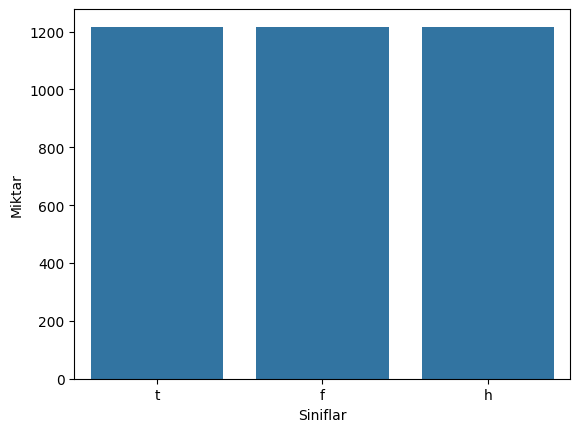

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
df_graph = pd.DataFrame({
    "Siniflar" : concat_df["label"].value_counts().index,
    "Miktar": concat_df["label"].value_counts().values
})
fig, ax = plt.subplots()
sns.barplot(data=df_graph, x="Siniflar", y="Miktar")

In [35]:
concat_df

Value__variance_larger_than_standard_deviation  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
3646                                             0.0   
3647                                             0.0   
3648                                             0.0   
3649                                             0.0   
3650                                             0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
3646                       0.0                       0.0   
3647                       0.0                       0.0   
3648                       0.0                       0.0   
3649                       0.0                       0.0   
3650                       0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
0                      0.0          71.862777          75.207139   
1                      0.0          37.556954          37.348964   
2                      1.0         226.013347         239.473686   
3                      0.0          32.127230          35.105982   
4                      0.0          31.938849          36.302070   
...                    ...                ...                ...   
3646                   0.0         230.699147         233.586374   
3647                   0.0          32.206716          34.990767   
3648                   1.0          34.741354          34.237073   
3649                   0.0         231.702471         233.993573   
3650                   0.0           7.538159           8.462633   

      Value__mean_abs_change  Value__mean_change  \
0                   0.272613            0.001377   
1                   0.215981           -0.009067   
2                   0.232413            0.000099   
3                   0.361140           -0.005197   
4                   0.385671            0.009643   
...                      ...                 ...   
3646                0.097945           -0.000050   
3647                0.414122           -0.001837   
3648                0.114108           -0.002703   
3649                0.058562           -0.000271   
3650                0.415514            0.002968   

      Value__mean_second_derivative_central  Value__median  ...  \
0                                  0.001549       0.969388  ...   
1                                  0.007826       0.952260  ...   
2                                  0.000253       0.980244  ...   
3                                 -0.000507       0.950722  ...   
4                                 -0.005076       0.904634  ...   
...                                     ...            ...  ...   
3646                              -0.000057       1.001464  ...   
3647                              -0.022289       0.877517  ...   
3648                               0.000384       1.001990  ...   
3649                               0.000208       1.012578  ...   
3650                               0.013367       0.767754  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
0                           1.266719                         1.944823   
1                           1.501327                         2.055845   
2                           1.187330                         1.857630   
3                           1.232405                         1.676696   


## 3) Encoding-Category

### a) Dataframe'imdeki t, f, h kategorilerini sayısal değerlere dönüştüreceğim.

In [36]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(categories="auto",sparse_output = False)

label_df = concat_df["label"]
encoder.fit(label_df.values.reshape(-1,1))
encoded_labels = encoder.transform(label_df.values.reshape(-1,1))
concat_df[["encoded_labelf","encoded_labelh","encoded_labelt"]] = encoded_labels

<ipython-input-36-eacc72818292>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df[["encoded_labelf","encoded_labelh","encoded_labelt"]] = encoded_labels
<ipython-input-36-eacc72818292>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  concat_df[["encoded_labelf","encoded_labelh","encoded_labelt"]] = encoded_labels
<ipython-input-36-eacc72818292>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns

In [37]:
concat_df

Value__variance_larger_than_standard_deviation  \
0                                                0.0   
1                                                0.0   
2                                                0.0   
3                                                0.0   
4                                                0.0   
...                                              ...   
3646                                             0.0   
3647                                             0.0   
3648                                             0.0   
3649                                             0.0   
3650                                             0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
0                          0.0                       0.0   
1                          0.0                       0.0   
2                          0.0                       0.0   
3                          0.0                       0.0   
4                          0.0                       0.0   
...                        ...                       ...   
3646                       0.0                       0.0   
3647                       0.0                       0.0   
3648                       0.0                       0.0   
3649                       0.0                       0.0   
3650                       0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
0                      0.0          71.862777          75.207139   
1                      0.0          37.556954          37.348964   
2                      1.0         226.013347         239.473686   
3                      0.0          32.127230          35.105982   
4                      0.0          31.938849          36.302070   
...                    ...                ...                ...   
3646                   0.0         230.699147         233.586374   
3647                   0.0          32.206716          34.990767   
3648                   1.0          34.741354          34.237073   
3649                   0.0         231.702471         233.993573   
3650                   0.0           7.538159           8.462633   

      Value__mean_abs_change  Value__mean_change  \
0                   0.272613            0.001377   
1                   0.215981           -0.009067   
2                   0.232413            0.000099   
3                   0.361140           -0.005197   
4                   0.385671            0.009643   
...                      ...                 ...   
3646                0.097945           -0.000050   
3647                0.414122           -0.001837   
3648                0.114108           -0.002703   
3649                0.058562           -0.000271   
3650                0.415514            0.002968   

      Value__mean_second_derivative_central  Value__median  ...  \
0                                  0.001549       0.969388  ...   
1                                  0.007826       0.952260  ...   
2                                  0.000253       0.980244  ...   
3                                 -0.000507       0.950722  ...   
4                                 -0.005076       0.904634  ...   
...                                     ...            ...  ...   
3646                              -0.000057       1.001464  ...   
3647                              -0.022289       0.877517  ...   
3648                               0.000384       1.001990  ...   
3649                               0.000208       1.012578  ...   
3650                               0.013367       0.767754  ...   

      Value__permutation_entropy__dimension_3__tau_1  \
0                                           1.782669   
1                                           1.713189   
2                                           1.790054   
3                                           1.778336   
4                                           1.757620   
...                          

## 4) Transformation

### a) Giriş değişkenlerimin bazılarına transformation adımını uygulayarak makine öğrenimi modellerimin performanısının artıp atmadığını gözlemleyeceğiz.

In [38]:
import scipy.stats as stats
import matplotlib.pyplot as plt

1. Histogram: İlk grafik, belirtilen değişkenin dağılımını gösteren bir histogramdır. Histogram, değişkenin frekans dağılımını gösterir ve verinin yoğunluk bölgelerini belirlemeye yardımcı olur. plt.subplot(1, 2, 1) ile belirtilen 1. konumda histogram çizilir.

2. Q-Q (Quantile-Quantile) Çizimi: İkinci grafik, belirtilen değişkenin normal dağılıma ne kadar yakın olduğunu gösteren bir Q-Q çizimidir. Bu çizim, belirli bir dağılımı test etmek için gerçek değerlerin ve o dağılıma ait beklenen değerlerin karşılaştırılmasını sağlar. Eğer veri normal bir dağılıma sahipse, noktalar genellikle çizgi üzerinde düzgün bir şekilde yayılmış olur. plt.subplot(1, 2, 2) ile belirtilen 2. konumda Q-Q çizimi çizilir.

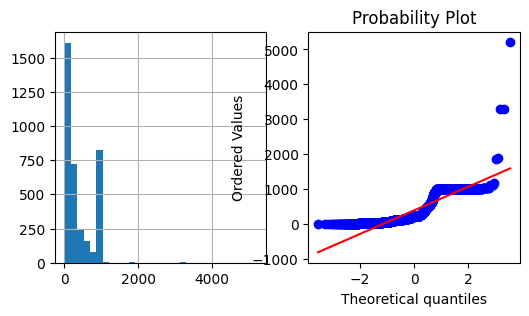

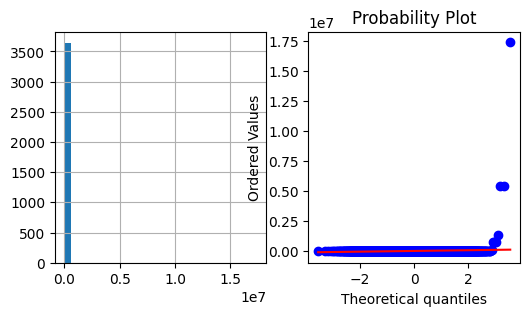

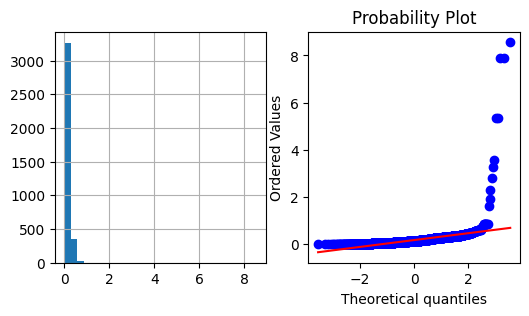

In [39]:
def diagnostic_plots(df, variable):
    plt.figure(figsize=(6,3))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()
diagnostic_plots(concat_df, "Value__sum_values")
diagnostic_plots(concat_df, "Value__abs_energy")
diagnostic_plots(concat_df, "Value__mean_abs_change")

Aşağıda görüldüğü üzere yeo-johnson dönüşümünü uyguladıktan sonra verimizin değişkenleri normal dağılıma daha çok yaklaştı

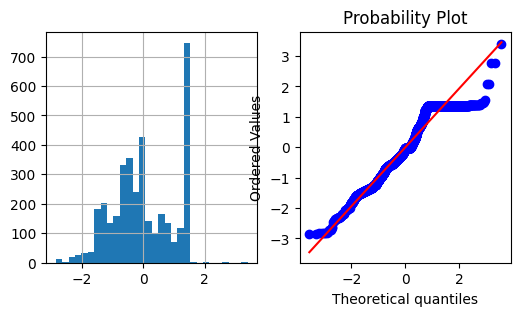

In [40]:
from sklearn.preprocessing import PowerTransformer
data_tf = concat_df.copy()
transformer = PowerTransformer(method="yeo-johnson")
data_tf[["Value__sum_values"]] = transformer.fit_transform(data_tf[['Value__sum_values']])
diagnostic_plots(data_tf, "Value__sum_values")

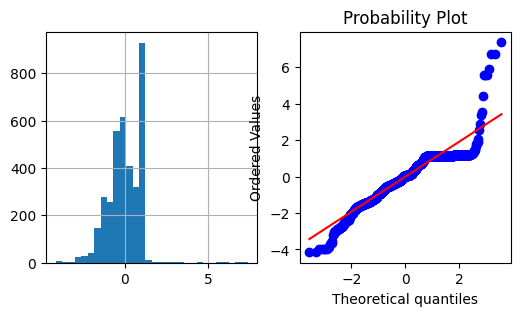

In [41]:
transformer = PowerTransformer(method="yeo-johnson")
data_tf[["Value__abs_energy"]] = transformer.fit_transform(data_tf[['Value__abs_energy']])
diagnostic_plots(data_tf, "Value__abs_energy")

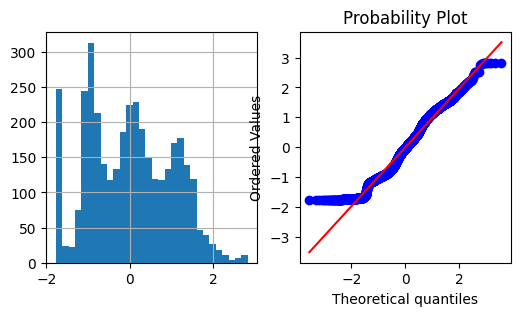

In [42]:
transformer = PowerTransformer(method="yeo-johnson")
data_tf[["Value__mean_abs_change"]] = transformer.fit_transform(data_tf[['Value__mean_abs_change']])
diagnostic_plots(data_tf, "Value__mean_abs_change")

## 5) Scaling

### a) Sayısal değişkenlerime min-max scaler işlemi uygulayacağım.

In [43]:
concat_df[sayisal_degiskenler].describe()

Value__variance_larger_than_standard_deviation  \
count                                     3651.000000   
mean                                         0.008491   
std                                          0.091766   
min                                          0.000000   
25%                                          0.000000   
50%                                          0.000000   
75%                                          0.000000   
max                                          1.000000   

       Value__has_duplicate_max  Value__has_duplicate_min  \
count               3651.000000               3651.000000   
mean                   0.000274                  0.001096   
std                    0.016550                  0.033086   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    0.000000                  0.000000   
75%                    0.000000                  0.000000   
max                    1.000000                  1.000000   

       Value__has_duplicate  Value__sum_values  Value__abs_energy  \
count           3651.000000        3651.000000       3.651000e+03   
mean               0.625582         389.574503       9.157826e+03   
std                0.484039         384.776659       3.157331e+05   
min                0.000000           0.763889       5.835262e-01   
25%                0.000000         104.464962       1.090583e+02   
50%                1.000000         228.496596       2.348737e+02   
75%                1.000000         701.605511       7.333596e+02   
max                1.000000        5206.220431       1.736251e+07   

       Value__mean_abs_change  Value__mean_change  \
count             3651.000000         3651.000000   
mean                 0.153344            0.000147   
std                  0.299969            0.011921   
min                  0.001262           -0.324303   
25%                  0.052187           -0.000187   
50%                  0.115245            0.000007   
75%                  0.205453            0.000236   
max                  8.562558            0.311058   

       Value__mean_second_derivative_central  Value__median  ...  \
count                            3651.000000    3651.000000  ...   
mean                               -0.000239       0.988788  ...   
std                                 0.011944       0.029948  ...   
min                                -0.243978       0.750356  ...   
25%                                -0.000238       0.985814  ...   
50%                                -0.000015       1.000000  ...   
75%                                 0.000132       1.001336  ...   
max                                 0.378458       1.361842  ...   

       Value__fourier_entropy__bins_3  Value__fourier_entropy__bins_5  \
count                     3651.000000                     3651.000000   
mean                         0.735353                        1.170927   
std                          0.190382                        0.221892   
min                         -0.000000                       -0.000000   
25%                          0.615011                        1.049767   
50%                          0.755633                        1.206363   
75%                          0.880042                        1.329395   
max                          1.098612                        1.601044   

       Value__fourier_entropy__bins_10  Value__fourier_entropy__bins_100  \
count                      3651.000000                       3651.000000   
mean                          1.770940                          3.457917   
std                           0.261975                          0.522705   
min                          -0.000000                         -0.000000   
25%                           1.653464                          3.265919   
50%                           1.816093                          3.610226   
75%                           1.947025  

In [44]:
from sklearn.preprocessing import MinMaxScaler
scaler_std = MinMaxScaler()
scaler_std.fit(concat_df[sayisal_degiskenler])
scaled_std = scaler_std.transform(concat_df[sayisal_degiskenler])
concat_df[sayisal_degiskenler] = scaled_std

In [45]:
concat_df[sayisal_degiskenler].describe()

Value__variance_larger_than_standard_deviation  \
count                                     3651.000000   
mean                                         0.008491   
std                                          0.091766   
min                                          0.000000   
25%                                          0.000000   
50%                                          0.000000   
75%                                          0.000000   
max                                          1.000000   

       Value__has_duplicate_max  Value__has_duplicate_min  \
count               3651.000000               3651.000000   
mean                   0.000274                  0.001096   
std                    0.016550                  0.033086   
min                    0.000000                  0.000000   
25%                    0.000000                  0.000000   
50%                    0.000000                  0.000000   
75%                    0.000000                  0.000000   
max                    1.000000                  1.000000   

       Value__has_duplicate  Value__sum_values  Value__abs_energy  \
count           3651.000000        3651.000000        3651.000000   
mean               0.625582           0.074693           0.000527   
std                0.484039           0.073918           0.018185   
min                0.000000           0.000000           0.000000   
25%                0.000000           0.019922           0.000006   
50%                1.000000           0.043749           0.000013   
75%                1.000000           0.134636           0.000042   
max                1.000000           1.000000           1.000000   

       Value__mean_abs_change  Value__mean_change  \
count             3651.000000         3651.000000   
mean                 0.017764            0.510655   
std                  0.035038            0.018762   
min                  0.000000            0.000000   
25%                  0.005948            0.510129   
50%                  0.013314            0.510434   
75%                  0.023851            0.510795   
max                  1.000000            1.000000   

       Value__mean_second_derivative_central  Value__median  ...  \
count                            3651.000000    3651.000000  ...   
mean                                0.391590       0.389922  ...   
std                                 0.019189       0.048976  ...   
min                                 0.000000       0.000000  ...   
25%                                 0.391591       0.385058  ...   
50%                                 0.391950       0.408257  ...   
75%                                 0.392185       0.410442  ...   
max                                 1.000000       1.000000  ...   

       Value__fourier_entropy__bins_3  Value__fourier_entropy__bins_5  \
count                     3651.000000                     3651.000000   
mean                         0.669347                        0.731352   
std                          0.173293                        0.138592   
min                          0.000000                        0.000000   
25%                          0.559808                        0.655676   
50%                          0.687807                        0.753485   
75%                          0.801049                        0.830330   
max                          1.000000                        1.000000   

       Value__fourier_entropy__bins_10  Value__fourier_entropy__bins_100  \
count                      3651.000000                       3651.000000   
mean                          0.782530                          0.825529   
std                           0.115760                          0.124789   
min                           0.000000                          0.000000   
25%                           0.730621                          0.779692   
50%                           0.802482                          0.861891   
75%                           0.860338  

## 6) Outliers

### a) Local Outlier Detection, yöntemi ile verisetindeki outlier'ları tespit edip bu outlierları sileceğim

In [46]:
from sklearn.neighbors import LocalOutlierFactor
outlier_LOF = LocalOutlierFactor(n_neighbors=5)
outlier_LOF_index= np.where(outlier_LOF.fit_predict(concat_df[sayisal_degiskenler])==-1)
outlier_LOF_index

(array([  39,  103,  121,  163,  224,  233,  262,  315,  320,  365,  367,
         369,  396,  409,  419,  452,  454,  489,  551,  554,  618,  745,
         779,  781,  953, 1309, 1545, 1686, 1785, 1802, 1820, 1864, 1957,
        2103, 2182, 2202, 2222, 2311, 2318, 2337, 2346, 2352, 2475, 2545,
        2569, 2592, 2642, 2644, 2668, 2676, 2722, 2862, 2870, 2927, 2930,
        3313, 3356, 3433, 3463, 3491, 3583, 3615, 3627, 3633]),)

Çok fazla outlier değerim olmadığı için outlier değerler barındıran satırları sileceğim

In [47]:
list(outlier_LOF_index[0])

[39,
 103,
 121,
 163,
 224,
 233,
 262,
 315,
 320,
 365,
 367,
 369,
 396,
 409,
 419,
 452,
 454,
 489,
 551,
 554,
 618,
 745,
 779,
 781,
 953,
 1309,
 1545,
 1686,
 1785,
 1802,
 1820,
 1864,
 1957,
 2103,
 2182,
 2202,
 2222,
 2311,
 2318,
 2337,
 2346,
 2352,
 2475,
 2545,
 2569,
 2592,
 2642,
 2644,
 2668,
 2676,
 2722,
 2862,
 2870,
 2927,
 2930,
 3313,
 3356,
 3433,
 3463,
 3491,
 3583,
 3615,
 3627,
 3633]

In [48]:
concat_df.drop(list(outlier_LOF_index[0]), axis=0, inplace=True)

# 4.Aşama: Model Eğitimi

## 1) KNeighborsClassifier modeli ile eğitim

In [49]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Eğitim
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 10), 'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}
clf = GridSearchCV(knn, param_grid, cv=5)
X = concat_df.drop(["encoded_labelf","encoded_labelh","encoded_labelt","label"], axis=1)
y = concat_df[["encoded_labelf","encoded_labelh","encoded_labelt"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
clf.fit(X_train, y_train)
y_predict = clf.predict(X_test)

### KNeighborsClassifier modelini test etmek

In [50]:
from sklearn.preprocessing import LabelEncoder

# Testler
accuracy = accuracy_score(y_test, y_predict)
precision = precision_score(y_test, y_predict, average='macro')
recall = recall_score(y_test, y_predict, average='macro')
f1 = f1_score(y_test, y_predict, average='macro')
print(f"Doğruluk: {accuracy}")
print(f"Hassasiyet: {precision}")
print(f"Geri Çağırma: {recall}")
print(f"F1-Score: {f1}")

Doğruluk: 0.9164345403899722
Hassasiyet: 0.9273444925851381
Geri Çağırma: 0.9168676134986664
F1-Score: 0.9204132125184756


In [51]:
# 0 0 1 -> technology
# 0 1 0 -> health
# 1 0 0 -> finance
y_predict

array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [52]:
X_train

Value__variance_larger_than_standard_deviation  \
2062                                             0.0   
1433                                             0.0   
2254                                             0.0   
3402                                             0.0   
3006                                             0.0   
...                                              ...   
3332                                             0.0   
3180                                             0.0   
1344                                             0.0   
744                                              0.0   
2916                                             0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
2062                       0.0                       0.0   
1433                       0.0                       0.0   
2254                       0.0                       0.0   
3402                       0.0                       0.0   
3006                       0.0                       0.0   
...                        ...                       ...   
3332                       0.0                       0.0   
3180                       0.0                       0.0   
1344                       0.0                       0.0   
744                        0.0                       0.0   
2916                       0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
2062                   0.0           0.012531           0.000004   
1433                   1.0           0.192780           0.000058   
2254                   1.0           0.053684           0.000016   
3402                   1.0           0.019892           0.000006   
3006                   0.0           0.014412           0.000004   
...                    ...                ...                ...   
3332                   0.0           0.022492           0.000007   
3180                   1.0           0.022159           0.000007   
1344                   0.0           0.133999           0.000040   
744                    0.0           0.010353           0.000004   
2916                   1.0           0.193181           0.000059   

      Value__mean_abs_change  Value__mean_change  \
2062                0.022983            0.515181   
1433                0.004836            0.510357   
2254                0.015016            0.509801   
3402                0.023728            0.506314   
3006                0.008391            0.508360   
...                      ...                 ...   
3332                0.014931            0.509188   
3180                0.000356            0.510338   
1344                0.005643            0.510332   
744                 0.035088            0.513840   
2916                0.012049            0.509261   

      Value__mean_second_derivative_central  Value__median  ...  \
2062                               0.389872       0.331726  ...   
1433                               0.391969       0.408257  ...   
2254                               0.391893       0.390286  ...   
3402                               0.391652       0.408257  ...   
3006                               0.391139       0.401788  ...   
...                                     ...            ...  ...   
3332                               0.390467       0.448168  ...   
3180                               0.391933       0.409815  ...   
1344                               0.391976       0.417668  ...   
744                                0.385041       0.300967  ...   
2916                               0.392459       0.408257  ...   

      Value__fourier_entropy__bins_3  Value__fourier_entropy__bins_5  \
2062                        0.825757                        0.796697   
1433                        0.746487                        0.775380   
2254                        0.425569                        0.567583   
3402                        0.568767                        0.722471   
3006 

## 2) Random forest classificiaton modeli ile eğitim

In [ ]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt
#
# # Eğitim
# rf = RandomForestClassifier()
# param_grid={'max_depth':[3,5,10,None],
#               'n_estimators':[10,100,200],
#               'max_features':[1,3,5,7],
#               'min_samples_leaf':[1,2,3],
#               'min_samples_split':[1,2,3]
#            }
# clf_rf = GridSearchCV(rf, param_grid, cv=3)
# X = concat_df.drop(["encoded_labelf","encoded_labelh","encoded_labelt","label"], axis=1)
# y = concat_df[["encoded_labelf","encoded_labelh","encoded_labelt"]]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
# clf_rf.fit(X_train, y_train)
# y_predict = clf_rf.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
432 fits failed out of a total of 1296.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
432 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/u

### RandomForest classifier modelini test etmek

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# # Testler
# accuracy = accuracy_score(y_test, y_predict)
# precision = precision_score(y_test, y_predict, average='macro')
# recall = recall_score(y_test, y_predict, average='macro')
# f1 = f1_score(y_test, y_predict, average='macro')
# print(f"Doğruluk: {accuracy}")
# print(f"Hassasiyet: {precision}")
# print(f"Geri Çağırma: {recall}")
# print(f"F1-Score: {f1}")

Doğruluk: 0.914572864321608
Hassasiyet: 0.935381512334229
Geri Çağırma: 0.917127947553911
F1-Score: 0.926049360850593


# 5.Aşama: Modelimizin diğer sektörlerdeki davranışları


## a) Endüstri sektorunde bulunan butun sembollerin cogunluğu hangi sektore(T,F,H) benzedigi bilgisi için yukarıda eğittiğimiz modeli kullanacağım.

In [53]:
!pip install tsfresh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 9.0 MB/s eta 0:00:00


In [54]:
import tsfresh

In [55]:
industrial = pd.read_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/industrials.csv').Symbol.to_list()

In [56]:
data_industrial = yfinance.download(industrial, start='2005-01-01')
data_close_industrial=data_industrial['Adj Close'].resample('W-MON').last().pct_change()+1

[*********************100%%**********************]  653 of 653 completed
ERROR:yfinance:
5 Failed downloads:
ERROR:yfinance:['UHAL.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2005-01-01 -> 2024-03-18)')
ERROR:yfinance:['WSO.B', 'MOG.B', 'HEI.A', 'MOG.A']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [57]:
data_close_industrial

Ticker           AAL       AAN      AAON       ABM       ACA      ACCO  \
Date                                                                     
2005-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-10       NaN       NaN  0.960026  0.998414       NaN       NaN   
2005-01-17       NaN       NaN  1.008328  0.971102       NaN       NaN   
2005-01-24       NaN       NaN  0.964212  0.986294       NaN       NaN   
2005-01-31       NaN       NaN  1.033548  1.017232       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-02-19  0.980576  0.973148  1.025548  0.988310  0.982579  0.993884   
2024-02-26  1.043716  0.995243  1.011269  1.006161  0.979134  0.895385   
2024-03-04  0.969241  0.688336  0.967742  1.010531  1.045208  0.938144   
2024-03-11  0.989196  0.980556  0.966424  1.018177  0.988332  0.987179   
2024-03-18  0.952901  1.002370  1.035134  1.007141  0.973050  0.987719   

Ticker          ACHR       ACM      ACTG       ADP  ...       XOS       XPO  \
Date                                                ...                       
2005-01-03       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2005-01-10       NaN       NaN  1.001898  0.972178  ...       NaN  0.812500   
2005-01-17       NaN       NaN  1.013258  0.994605  ...       NaN  1.196582   
2005-01-24       NaN       NaN  1.100934  1.020048  ...       NaN  0.921428   
2005-01-31       NaN       NaN  0.974533  1.005318  ...       NaN  0.937985   
...              ...       ...       ...       ...  ...       ...       ...   
2024-02-19  0.937388  0.989132  0.969907  1.011597  ...  0.993695  1.023803   
2024-02-26  0.938931  1.003139  0.947494  1.002293  ...  0.987310  1.000415   
2024-03-04  0.910569  1.003800  1.022670  0.971012  ...  1.744216  1.007470   
2024-03-11  1.066964  1.017147  0.990148  0.997157  ...  0.915991  1.004861   
2024-03-18  1.050209  1.002518  1.156716  0.991806  ...  1.023331  1.005657   

Ticker          XPON       XYL      YGMZ      ZCAR       ZIM       ZIP  \
Date                                                                     
2005-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-10       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-17       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-24       NaN       NaN       NaN       NaN       NaN       NaN   
2005-01-31       NaN       NaN       NaN       NaN       NaN       NaN   
...              ...       ...       ...       ...       ...       ...   
2024-02-19  0.992925  1.003974  0.998039  0.837838  1.041288  0.978231   
2024-02-26  0.923991  1.018472  0.978389  1.000000  0.966693  0.866481   
2024-03-04  0.838046  1.017023  1.082329  0.961290  0.898277  1.013644   
2024-03-11  1.058282  0.986938  0.909091  0.805369  1.042009  0.981789   
2024-03-18  0.959420  1.008638  0.973469  0.941667  0.828221  0.930645   

Ticker           ZTO       ZWS  
Date                            
2005-01-03       NaN       NaN  
2005-01-10       NaN       NaN  
2005-01-17       NaN       NaN  
2005-01-24       NaN       NaN  
2005-01-31       NaN       NaN  
...              ...       ...  
2024-02-19  1.058419  0.960329  
2024-02-26  1.031926  1.010978  
2024-03-04  1.072365  1.023954  
2024-03-11  0.982885  0.983468  
2024-03-18  1.085075  0.999683  

[1003 rows x 653 columns]

In [58]:
industrial_df = data_close_industrial
industrial_df.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/industrialCompanies.csv")

In [59]:
industrial_df = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/industrialCompanies.csv")

In [60]:
reindustrial = pd.melt(industrial_df, id_vars=["Date"], value_vars=list(industrial_df.columns), var_name="Ticker", value_name="Value")

In [61]:
reindustrial

Date Ticker     Value
0       2005-01-03    AAL       NaN
1       2005-01-10    AAL       NaN
2       2005-01-17    AAL       NaN
3       2005-01-24    AAL       NaN
4       2005-01-31    AAL       NaN
...            ...    ...       ...
654954  2024-02-19    ZWS  0.960329
654955  2024-02-26    ZWS  1.010978
654956  2024-03-04    ZWS  1.023954
654957  2024-03-11    ZWS  0.983468
654958  2024-03-18    ZWS  0.999683

[654959 rows x 3 columns]

In [62]:
reindustrial.dropna(inplace=True)

In [63]:
reindustrial

Date Ticker     Value
40      2005-10-10    AAL  1.033023
41      2005-10-17    AAL  0.994147
42      2005-10-24    AAL  1.010417
43      2005-10-31    AAL  1.106230
44      2005-11-07    AAL  1.172204
...            ...    ...       ...
654954  2024-02-19    ZWS  0.960329
654955  2024-02-26    ZWS  1.010978
654956  2024-03-04    ZWS  1.023954
654957  2024-03-11    ZWS  0.983468
654958  2024-03-18    ZWS  0.999683

[457446 rows x 3 columns]

In [64]:
reindustrial_ex = tsfresh.extract_features(reindustrial, column_id="Ticker",column_sort="Date", column_value="Value",default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())

Feature Extraction: 100%|██████████| 648/648 [08:35<00:00,  1.26it/s]


In [65]:
reindustrial_ex

Value__variance_larger_than_standard_deviation  \
AAL                                              0.0   
AAN                                              0.0   
AAON                                             0.0   
ABM                                              0.0   
ACA                                              0.0   
...                                              ...   
ZCAR                                             0.0   
ZIM                                              0.0   
ZIP                                              0.0   
ZTO                                              0.0   
ZWS                                              0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
AAL                        0.0                       0.0   
AAN                        0.0                       0.0   
AAON                       0.0                       0.0   
ABM                        0.0                       0.0   
ACA                        0.0                       0.0   
...                        ...                       ...   
ZCAR                       0.0                       0.0   
ZIM                        0.0                       0.0   
ZIP                        0.0                       0.0   
ZTO                        0.0                       0.0   
ZWS                        0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
AAL                    1.0         966.749137         979.161797   
AAN                    1.0         171.612666         172.255332   
AAON                   1.0        1007.185555        1014.971751   
ABM                    1.0        1004.221567        1008.413762   
ACA                    0.0         281.456037         283.744631   
...                    ...                ...                ...   
ZCAR                   1.0         112.835374         113.140385   
ZIM                    0.0         164.308144         167.229654   
ZIP                    0.0         145.807011         146.388123   
ZTO                    1.0         385.943583         388.111007   
ZWS                    1.0         625.223430         627.976769   

      Value__mean_abs_change  Value__mean_change  \
AAL                 0.086242           -0.000083   
AAN                 0.081648            0.000376   
AAON                0.055053            0.000075   
ABM                 0.044810            0.000009   
ACA                 0.056971           -0.000242   
...                      ...                 ...   
ZCAR                0.060481           -0.000437   
ZIM                 0.102978           -0.001776   
ZIP                 0.081298           -0.001338   
ZTO                 0.060308            0.000452   
ZWS                 0.050709            0.000019   

      Value__mean_second_derivative_central  Value__median  ...  \
AAL                            1.343055e-06       0.998556  ...   
AAN                           -1.149572e-04       0.997106  ...   
AAON                           1.020395e-05       1.005006  ...   
ABM                            8.138098e-06       1.001700  ...   
ACA                            4.596414e-05       1.003192  ...   
...                                     ...            ...  ...   
ZCAR                           5.727971e-04       1.000994  ...   
ZIM                           -1.308903e-03       1.001641  ...   
ZIP                            5.830898e-04       1.011283  ...   
ZTO                            1.141927e-04       1.003331  ...   
ZWS                           -3.252611e-07       1.003842  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
AAL                         1.235750                         1.848163   
AAN                         1.179737                         1.780626   
AAON                        1.316932                         1.916043   
ABM                         1.464667                         2.122365   


In [66]:
reindustrial_ex.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/reindustrial_ex.csv")


 ### 1) extract edilmiş endüstri değerlerini vakit kaybetmeden çağırmak için buradan itibaren çalıştırabiliriz.

**vakit kaybetmemek için buradan itibaren çalıştırabilirsiniz**

In [67]:
reindustrial_ex = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/reindustrial_ex.csv")

In [68]:
reindustrial_ex

Unnamed: 0  Value__variance_larger_than_standard_deviation  \
0          AAL                                             0.0   
1          AAN                                             0.0   
2         AAON                                             0.0   
3          ABM                                             0.0   
4          ACA                                             0.0   
..         ...                                             ...   
643       ZCAR                                             0.0   
644        ZIM                                             0.0   
645        ZIP                                             0.0   
646        ZTO                                             0.0   
647        ZWS                                             0.0   

     Value__has_duplicate_max  Value__has_duplicate_min  Value__has_duplicate  \
0                         0.0                       0.0                   1.0   
1                         0.0                       0.0                   1.0   
2                         0.0                       0.0                   1.0   
3                         0.0                       0.0                   1.0   
4                         0.0                       0.0                   0.0   
..                        ...                       ...                   ...   
643                       0.0                       0.0                   1.0   
644                       0.0                       0.0                   0.0   
645                       0.0                       0.0                   0.0   
646                       0.0                       0.0                   1.0   
647                       0.0                       0.0                   1.0   

     Value__sum_values  Value__abs_energy  Value__mean_abs_change  \
0           966.749137         979.161797                0.086242   
1           171.612666         172.255332                0.081648   
2          1007.185555        1014.971751                0.055053   
3          1004.221567        1008.413762                0.044810   
4           281.456037         283.744631                0.056971   
..                 ...                ...                     ...   
643         112.835374         113.140385                0.060481   
644         164.308144         167.229654                0.102978   
645         145.807011         146.388123                0.081298   
646         385.943583         388.111007                0.060308   
647         625.223430         627.976769                0.050709   

     Value__mean_change  Value__mean_second_derivative_central  ...  \
0             -0.000083                           1.343055e-06  ...   
1              0.000376                          -1.149572e-04  ...   
2              0.000075                           1.020395e-05  ...   
3              0.000009                           8.138098e-06  ...   
4             -0.000242                           4.596414e-05  ...   
..                  ...                                    ...  ...   
643           -0.000437                           5.727971e-04  ...   
644           -0.001776                          -1.308903e-03  ...   
645           -0.001338                           5.830898e-04  ...   
646            0.000452                           1.141927e-04  ...   
647            0.000019                          -3.252611e-07  ...   

     Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
0                          1.235750                         1.848163   
1                          1.179737                         1.780626   
2                          1.316932                         1.916043   
3                          1.464667                         2.122365   
4                          1.130101                         1.771880   
..                              ...                              ...   
643                        0.629775                 

1-) bütün sütunu nan değerler olanları sil  
2-) infinitive değerleri 0 ile değiştir

In [69]:
reindustrial_ex.dropna(how="all",axis=1,inplace=True)
reindustrial_ex.replace([np.inf, -np.inf], 0, inplace=True)

 ### 2) Verisetimizin featurlarını değiştirirken modelimiz için kullanmış olduğumuz feature engineering adımlarını pipeline ile yapacağız.

In [70]:
from feature_engine.imputation import MeanMedianImputer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sayisal_degiskenler_industrial = reindustrial_ex.select_dtypes(include=[np.float64, np.int64]).columns

ImputerEngine = MeanMedianImputer(imputation_method="mean",variables=sayisal_degiskenler_industrial.to_list())
scaler_std = MinMaxScaler()
outlier_LOF = LocalOutlierFactor(n_neighbors=5)
def remove_outliers(X):
    outlier_mask = outlier_LOF.fit_predict(X) != -1
    return X[outlier_mask], ~outlier_mask

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler_std, sayisal_degiskenler_industrial)
    ])

pipeline = Pipeline(steps=[
    ('imputer', ImputerEngine),
    ('scaler', preprocessor),
    ('outlier_remover', FunctionTransformer(remove_outliers)),
])
reindustrial_ex_dataframe, outliers = pipeline.fit_transform(reindustrial_ex)

In [71]:
reindustrial_ex = reindustrial_ex[~outliers].reset_index(drop=True)

In [72]:
reindustrial_ex_dataframe = pd.DataFrame(reindustrial_ex_dataframe, columns=sayisal_degiskenler_industrial)

In [73]:
reindustrial_ex_dataframe

Value__variance_larger_than_standard_deviation  Value__has_duplicate_max  \
0                                               0.0                       0.0   
1                                               0.0                       0.0   
2                                               0.0                       0.0   
3                                               0.0                       0.0   
4                                               0.0                       0.0   
..                                              ...                       ...   
640                                             0.0                       0.0   
641                                             0.0                       0.0   
642                                             0.0                       0.0   
643                                             0.0                       0.0   
644                                             0.0                       0.0   

     Value__has_duplicate_min  Value__has_duplicate  Value__sum_values  \
0                         0.0                   1.0           0.930258   
1                         0.0                   1.0           0.164261   
2                         0.0                   1.0           0.969213   
3                         0.0                   1.0           0.966358   
4                         0.0                   0.0           0.270079   
..                        ...                   ...                ...   
640                       0.0                   1.0           0.107637   
641                       0.0                   0.0           0.157224   
642                       0.0                   0.0           0.139401   
643                       0.0                   1.0           0.370737   
644                       0.0                   1.0           0.601248   

     Value__abs_energy  Value__mean_abs_change  Value__mean_change  \
0             0.189590                0.058939            0.512165   
1             0.033158                0.054242            0.514843   
2             0.196532                0.027050            0.513087   
3             0.195261                0.016577            0.512701   
4             0.054772                0.029011            0.511243   
..                 ...                     ...                 ...   
640           0.021698                0.032600            0.510108   
641           0.032184                0.076051            0.502307   
642           0.028143                0.053884            0.504858   
643           0.075005                0.032423            0.515284   
644           0.121507                0.022608            0.512764   

     Value__mean_second_derivative_central  Value__median  ...  \
0                                 0.344418       0.414850  ...   
1                                 0.343808       0.409929  ...   
2                                 0.344464       0.436749  ...   
3                                 0.344454       0.425526  ...   
4                                 0.344652       0.430591  ...   
..                                     ...            ...  ...   
640                               0.347415       0.423126  ...   
641                               0.337547       0.425325  ...   
642                               0.347469       0.458058  ...   
643                               0.345010       0.431061  ...   
644                               0.344409       0.432796  ...   

     Value__fourier_entropy__bins_3  Value__fourier_entropy__bins_5  \
0                          0.721087                        0.754936   
1                          0.604668                        0.715003   
2                          0.774888                        0.812811   
3                          0.896460                        0.918134   
4                          0.603439                        0.679617   
..                              ...                             ...   
640         

In [74]:
reindustrial_ex

Unnamed: 0  Value__variance_larger_than_standard_deviation  \
0          AAL                                             0.0   
1          AAN                                             0.0   
2         AAON                                             0.0   
3          ABM                                             0.0   
4          ACA                                             0.0   
..         ...                                             ...   
640       ZCAR                                             0.0   
641        ZIM                                             0.0   
642        ZIP                                             0.0   
643        ZTO                                             0.0   
644        ZWS                                             0.0   

     Value__has_duplicate_max  Value__has_duplicate_min  Value__has_duplicate  \
0                         0.0                       0.0                   1.0   
1                         0.0                       0.0                   1.0   
2                         0.0                       0.0                   1.0   
3                         0.0                       0.0                   1.0   
4                         0.0                       0.0                   0.0   
..                        ...                       ...                   ...   
640                       0.0                       0.0                   1.0   
641                       0.0                       0.0                   0.0   
642                       0.0                       0.0                   0.0   
643                       0.0                       0.0                   1.0   
644                       0.0                       0.0                   1.0   

     Value__sum_values  Value__abs_energy  Value__mean_abs_change  \
0           966.749137         979.161797                0.086242   
1           171.612666         172.255332                0.081648   
2          1007.185555        1014.971751                0.055053   
3          1004.221567        1008.413762                0.044810   
4           281.456037         283.744631                0.056971   
..                 ...                ...                     ...   
640         112.835374         113.140385                0.060481   
641         164.308144         167.229654                0.102978   
642         145.807011         146.388123                0.081298   
643         385.943583         388.111007                0.060308   
644         625.223430         627.976769                0.050709   

     Value__mean_change  Value__mean_second_derivative_central  ...  \
0             -0.000083                           1.343055e-06  ...   
1              0.000376                          -1.149572e-04  ...   
2              0.000075                           1.020395e-05  ...   
3              0.000009                           8.138098e-06  ...   
4             -0.000242                           4.596414e-05  ...   
..                  ...                                    ...  ...   
640           -0.000437                           5.727971e-04  ...   
641           -0.001776                          -1.308903e-03  ...   
642           -0.001338                           5.830898e-04  ...   
643            0.000452                           1.141927e-04  ...   
644            0.000019                          -3.252611e-07  ...   

     Value__fourier_entropy__bins_3  Value__fourier_entropy__bins_5  \
0                          0.814280                        1.235750   
1                          0.697075                        1.179737   
2                          0.868445                        1.316932   
3                          0.990839                        1.464667   
4                          0.695837                        1.130101   
..                              ...                             ...   
640                        0.236484                        

### 3) Endüstri verilerimizi modelimize giriş değişkeni olarak veriyoruz ve endüstri şirketlerinin teknoloji, sağlık ve finans alanlarından hangisine daha çok benzediğinin değerlendirmesini yapıyoruz.

In [75]:
industrial_pred = clf.predict(reindustrial_ex_dataframe)

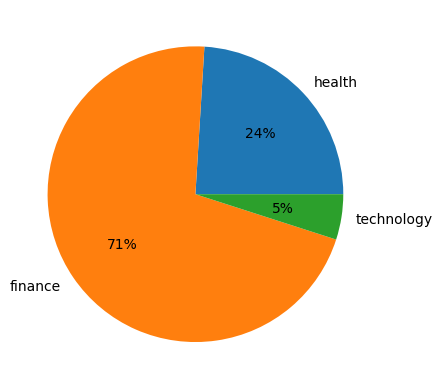

In [82]:
# 0 0 1 -> technology np.argmax = 2
# 0 1 0 -> health np.argmax = 1
# 1 0 0 -> finance np.argmax = 0
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

sector_names = ['finance', 'health', 'technology']
pred_sector_list = np.argmax(industrial_pred, axis=1)
sector_pred_list = [sector_names[pred] for pred in pred_sector_list]
sayac = dict(Counter(sector_pred_list))
etiketler = list(sayac.keys())
degerler = list(sayac.values())
plt.pie(degerler, labels=etiketler, autopct='%1.0f%%')
plt.show()

### 4) Endüstri sektöründeki şirketlerin yüzde 3'ünün teknoloji alanındaki şirketler ile alakası var. Endüstri alanındaki bu şirketlerin info verilerine göz atalım

In [96]:
indices = [i for i, sector in enumerate(sector_pred_list) if sector == "technology"]
endustrial_technology_company = reindustrial_ex["Unnamed: 0"][indices].to_list()

Endüstrideki şirketlerinin teknoloji şirketlerine benzeyen azınlık olanları aşağıda verilmiştir.

In [101]:
for company in endustrial_technology_company:
  ticker_name = yfinance.Ticker(company)
  print(f"{company} şirketinin info verisi: {ticker_name.info}")

AGFY şirketinin info verisi: {'address1': '2468 Industrial Row Dr', 'city': 'Troy', 'state': 'MI', 'zip': '48084', 'country': 'United States', 'phone': '855 420 0020', 'website': 'https://www.agrify.com', 'industry': 'Engineering & Construction', 'industryKey': 'engineering-construction', 'industryDisp': 'Engineering & Construction', 'sector': 'Industrials', 'sectorKey': 'industrials', 'sectorDisp': 'Industrials', 'longBusinessSummary': 'Agrify Corporation develops precision hardware and software cultivation and extraction solutions for the cannabis and hemp industry in the United States. The company offers vertical farming units and Agrify Insights Software-as-a-Service software; integrated grow racks and LED grow lights; and non-proprietary products designed, engineered, and manufactured by third parties, such as air cleaning systems and pesticide-free surface protection products. It also provides associated services comprising consulting, engineering, and construction. In addition, 

## b) Tüketici ihtiyaçları sektöründe bulunan butun sembollerin cogunluğu hangi sektore(T,F,H) benzedigi bilgisi için modelimi kullanacağım.

In [102]:
consumer = pd.read_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/consumer-discretionary.csv').Symbol.to_list()
data_consumer = yfinance.download(consumer, start='2005-01-01')
data_close_consumer=data_consumer['Adj Close'].resample('W-MON').last().pct_change()+1
consumer_df = data_close_consumer
consumer_df.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/consumerCompanies.csv")

[*********************100%%**********************]  577 of 577 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['GEF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 2005-01-01 -> 2024-03-18)')
ERROR:yfinance:['HVT.A']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [103]:
consumer_df = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/consumerCompanies.csv")
reconsumer = pd.melt(consumer_df, id_vars=["Date"], value_vars=list(consumer_df.columns), var_name="Ticker", value_name="Value")

In [104]:
reconsumer.dropna(inplace=True)

In [105]:
reconsumer_ex = tsfresh.extract_features(reconsumer, column_id="Ticker",column_sort="Date", column_value="Value",default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())

Feature Extraction: 100%|██████████| 575/575 [06:16<00:00,  1.53it/s]


In [106]:
reconsumer_ex

Value__variance_larger_than_standard_deviation  \
AAP                                              0.0   
ABG                                              0.0   
ABNB                                             0.0   
ACEL                                             0.0   
ACVA                                             0.0   
...                                              ...   
YUMC                                             0.0   
ZAPP                                             0.0   
ZGN                                              0.0   
ZKH                                              0.0   
ZUMZ                                             0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
AAP                        0.0                       0.0   
ABG                        0.0                       0.0   
ABNB                       0.0                       0.0   
ACEL                       0.0                       0.0   
ACVA                       0.0                       0.0   
...                        ...                       ...   
YUMC                       0.0                       0.0   
ZAPP                       0.0                       0.0   
ZGN                        0.0                       0.0   
ZKH                        0.0                       0.0   
ZUMZ                       0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
AAP                    1.0        1004.321850        1008.865049   
ABG                    0.0        1007.383860        1017.906795   
ABNB                   0.0         170.628036         172.083158   
ACEL                   1.0         342.614776         344.145496   
ACVA                   0.0         154.899848         155.800504   
...                    ...                ...                ...   
YUMC                   0.0         388.022923         389.980960   
ZAPP                   1.0         120.188846         118.695204   
ZGN                    1.0         117.456150         118.162024   
ZKH                    0.0          13.199460          13.435797   
ZUMZ                   1.0         986.900559         995.382340   

      Value__mean_abs_change  Value__mean_change  \
AAP                 0.047801        8.713658e-05   
ABG                 0.066520       -4.064125e-05   
ABNB                0.076091       -1.588273e-03   
ACEL                0.043703       -4.722905e-07   
ACVA                0.089228        2.279340e-04   
...                      ...                 ...   
YUMC                0.054872        5.047330e-05   
ZAPP                0.067528       -9.199127e-04   
ZGN                 0.051834       -5.513296e-04   
ZKH                 0.074132        6.889890e-03   
ZUMZ                0.079277       -8.561640e-05   

      Value__mean_second_derivative_central  Value__median  ...  \
AAP                               -0.000011       1.002270  ...   
ABG                               -0.000011       1.004067  ...   
ABNB                               0.000877       1.011523  ...   
ACEL                              -0.000027       1.000925  ...   
ACVA                               0.000302       0.997091  ...   
...                                     ...            ...  ...   
YUMC                               0.000035       1.001144  ...   
ZAPP                              -0.001098       1.000497  ...   
ZGN                                0.000801       0.999305  ...   
ZKH                                0.006465       1.003871  ...   
ZUMZ                              -0.000123       1.000529  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
AAP                         1.281180                         1.907903   
ABG                         1.081967                         1.717834   
ABNB                        0.825346                         1.482055   
ACEL                        1.123065                         1.767355   


In [107]:
reconsumer_ex.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/reconsumer_ex.csv")

### 1) extract edilmiş tüketici ihtiyaç sektörü değerlerini vakit kaybetmeden çağırmak için buradan itibaren çalıştırabiliriz.

In [108]:
reconsumer_ex = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/reconsumer_ex.csv")

1-) bütün sütunu nan değerler olanları sil  
2-) infinitive değerleri 0 ile değiştir

In [109]:
reconsumer_ex.dropna(how="all",axis=1,inplace=True)
reconsumer_ex.replace([np.inf, -np.inf], 0, inplace=True)

 ### 2) Verisetimizin featurlarını değiştirirken modelimiz için kullanmış olduğumuz feature engineering adımlarını pipeline ile yapacağız.

In [110]:
from feature_engine.imputation import MeanMedianImputer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sayisal_degiskenler_consumer= reconsumer_ex.select_dtypes(include=[np.float64, np.int64]).columns

ImputerEngine = MeanMedianImputer(imputation_method="mean",variables=sayisal_degiskenler_consumer.to_list())
scaler_std = MinMaxScaler()
outlier_LOF = LocalOutlierFactor(n_neighbors=5)
def remove_outliers(X):
    outlier_mask = outlier_LOF.fit_predict(X) != -1
    return X[outlier_mask], ~outlier_mask

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler_std, sayisal_degiskenler_consumer)
    ])

pipeline = Pipeline(steps=[
    ('imputer', ImputerEngine),
    ('scaler', preprocessor),
    ('outlier_remover', FunctionTransformer(remove_outliers)),
])
reconsumer_ex_dataframe, outliers = pipeline.fit_transform(reconsumer_ex)

In [111]:
reconsumer_ex = reconsumer_ex[~outliers].reset_index(drop=True)
reconsumer_ex_dataframe = pd.DataFrame(reconsumer_ex_dataframe, columns=sayisal_degiskenler_consumer)

### 3) Tüketici ihtiyacı  verilerimizi modelimize giriş değişkeni olarak veriyoruz ve endüstri şirketlerinin teknoloji, sağlık ve finans alanlarından hangisine daha çok benzediğinin değerlendirmesini yapıyoruz.

In [112]:
consumer_pred = clf.predict(reconsumer_ex_dataframe)

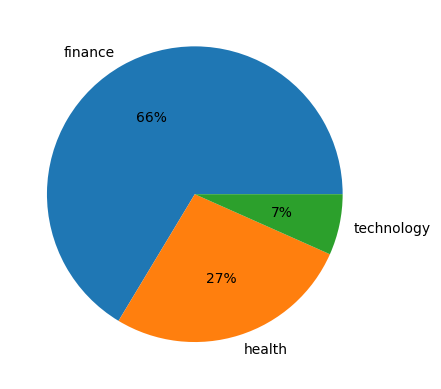

In [113]:
# 0 0 1 -> technology np.argmax = 2
# 0 1 0 -> health np.argmax = 1
# 1 0 0 -> finance np.argmax = 0
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

sector_names = ['finance', 'health', 'technology']
pred_sector_list = np.argmax(consumer_pred, axis=1)
sector_pred_list = [sector_names[pred] for pred in pred_sector_list]
sayac = dict(Counter(sector_pred_list))
etiketler = list(sayac.keys())
degerler = list(sayac.values())
plt.pie(degerler, labels=etiketler, autopct='%1.0f%%')
plt.show()

### 4) Tüketici ihtiyacı sektöründeli şirketlerin yüzde 7'sinin teknoloji alanındaki şirketler ile alakası var. Bu şirketlerin info verilerine göz atalım.

In [130]:
indices = [i for i, sector in enumerate(sector_pred_list) if sector == "technology"]
consumer_technology_company = reconsumer_ex["Unnamed: 0"][indices].to_list()

In [131]:
for company in consumer_technology_company:
  ticker_name = yfinance.Ticker(company)
  print(f"{company} şirketinin info verisi: {ticker_name.info}")

AIN şirketinin info verisi: {'address1': '216 Airport Drive', 'city': 'Rochester', 'state': 'NH', 'zip': '03867', 'country': 'United States', 'phone': '603 330 5800', 'fax': '603 994 3835', 'website': 'https://www.albint.com', 'industry': 'Textile Manufacturing', 'industryKey': 'textile-manufacturing', 'industryDisp': 'Textile Manufacturing', 'sector': 'Consumer Cyclical', 'sectorKey': 'consumer-cyclical', 'sectorDisp': 'Consumer Cyclical', 'longBusinessSummary': 'Albany International Corp., together with its subsidiaries, engages in the machine clothing and engineered composites businesses. The company operates in two segments, Machine Clothing (MC) and Albany Engineered Composites (AEC). The MC segment designs, manufactures, and markets paper machine clothing for use in the manufacturing of papers, paperboards, tissues, towels, pulps, nonwovens, building products, tannery, and textiles, as well as fiber cement and several other industrial applications. This segment offers paper machi

## c) Gayrimenkul sektöründe bulunan butun sembollerin cogunluğu hangi sektore(T,F,H) benzedigi bilgisi için modelimi kullanacağım.

In [117]:
estate = pd.read_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/real-estate.csv').Symbol.to_list()
data_estate = yfinance.download(estate, start='2005-01-01')
data_close_estate=data_estate['Adj Close'].resample('W-MON').last().pct_change()+1
estate_df = data_close_estate
estate_df.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/estateCompanies.csv")

[*********************100%%**********************]  261 of 261 completed


In [118]:
estate_df = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/estateCompanies.csv")
reestate = pd.melt(estate_df, id_vars=["Date"], value_vars=list(estate_df.columns), var_name="Ticker", value_name="Value")

In [120]:
reestate.dropna(inplace=True)

In [121]:
reestate_ex = tsfresh.extract_features(reestate, column_id="Ticker",column_sort="Date", column_value="Value",default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())

Feature Extraction: 100%|██████████| 261/261 [03:10<00:00,  1.37it/s]


In [122]:
reestate_ex

Value__variance_larger_than_standard_deviation  \
AAT                                              0.0   
ABR                                              0.0   
ACR                                              0.0   
ACRE                                             0.0   
ADC                                              0.0   
...                                              ...   
WPC                                              0.0   
WSR                                              0.0   
WY                                               0.0   
XHR                                              0.0   
XIN                                              0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
AAT                        0.0                       0.0   
ABR                        0.0                       0.0   
ACR                        0.0                       0.0   
ACRE                       0.0                       0.0   
ADC                        0.0                       0.0   
...                        ...                       ...   
WPC                        0.0                       0.0   
WSR                        0.0                       0.0   
WY                         0.0                       0.0   
XHR                        0.0                       0.0   
XIN                        0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
AAT                    0.0         687.970237         689.994889   
ABR                    1.0        1006.360225        1018.377644   
ACR                    1.0         946.451176         955.944743   
ACRE                   1.0         621.107058         623.913735   
ADC                    1.0        1004.791121        1009.887925   
...                    ...                ...                ...   
WPC                    0.0        1004.379467        1008.193173   
WSR                    1.0         708.754435         711.942959   
WY                     1.0        1004.020695        1008.084594   
XHR                    1.0         475.816358         478.362195   
XIN                    1.0         848.128890         855.422871   

      Value__mean_abs_change  Value__mean_change  \
AAT                 0.037090            0.000001   
ABR                 0.063839            0.000022   
ACR                 0.066081            0.000009   
ACRE                0.040149            0.000056   
ADC                 0.041646            0.000047   
...                      ...                 ...   
WPC                 0.036051            0.000039   
WSR                 0.042198           -0.000039   
WY                  0.043993           -0.000034   
XHR                 0.056471           -0.000055   
XIN                 0.092863           -0.000124   

      Value__mean_second_derivative_central  Value__median  ...  \
AAT                           -4.321057e-07       1.003044  ...   
ABR                           -2.574756e-05       1.002967  ...   
ACR                            1.370452e-05       1.000000  ...   
ACRE                           4.362213e-06       1.003158  ...   
ADC                           -5.160670e-05       1.003811  ...   
...                                     ...            ...  ...   
WPC                           -6.422738e-05       1.002920  ...   
WSR                            3.842394e-06       1.003945  ...   
WY                             5.924274e-06       1.002147  ...   
XHR                           -3.937496e-05       1.001419  ...   
XIN                            4.357914e-05       0.993756  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
AAT                         1.226352                         1.876670   
ABR                         1.306931                         1.949040   
ACR                         1.380734                         2.030031   
ACRE                        1.408661                         2.046095   


In [123]:
reestate_ex.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/reestate_ex.csv")

### 1) extract edilmiş gayrimenkul sektörü değerlerini vakit kaybetmeden çağırmak için buradan itibaren çalıştırabiliriz.

In [124]:
reestate_ex = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/reestate_ex.csv")

1-) bütün sütunu nan değerler olanları sil  
2-) infinitive değerleri 0 ile değiştir

In [125]:
reestate_ex.dropna(how="all",axis=1,inplace=True)
reestate_ex.replace([np.inf, -np.inf], 0, inplace=True)

 ### 2) Verisetimizin featurlarını değiştirirken modelimiz için kullanmış olduğumuz feature engineering adımlarını pipeline ile yapacağız.

In [126]:
from feature_engine.imputation import MeanMedianImputer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sayisal_degiskenler_estate= reestate_ex.select_dtypes(include=[np.float64, np.int64]).columns

ImputerEngine = MeanMedianImputer(imputation_method="mean",variables=sayisal_degiskenler_estate.to_list())
scaler_std = MinMaxScaler()
outlier_LOF = LocalOutlierFactor(n_neighbors=5)
def remove_outliers(X):
    outlier_mask = outlier_LOF.fit_predict(X) != -1
    return X[outlier_mask], ~outlier_mask

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler_std, sayisal_degiskenler_estate)
    ])

pipeline = Pipeline(steps=[
    ('imputer', ImputerEngine),
    ('scaler', preprocessor),
    ('outlier_remover', FunctionTransformer(remove_outliers)),
])
reestate_ex_dataframe, outliers = pipeline.fit_transform(reestate_ex)

In [127]:
reestate_ex = reestate_ex[~outliers].reset_index(drop=True)
reestate_ex_dataframe = pd.DataFrame(reestate_ex_dataframe, columns=sayisal_degiskenler_estate)

### 3) Gayrimenkul verilerimizi modelimize giriş değişkeni olarak veriyoruz ve materyal şirketlerinin teknoloji, sağlık ve finans alanlarından hangisine daha çok benzediğinin değerlendirmesini yapıyoruz.

In [128]:
estate_pred = clf.predict(reestate_ex_dataframe)

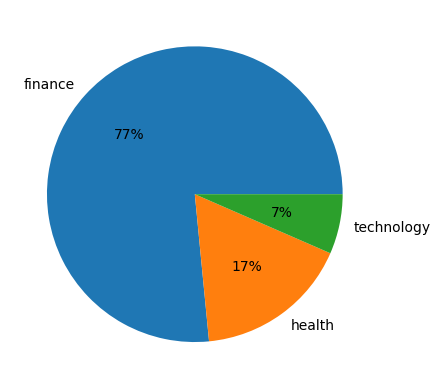

In [129]:
# 0 0 1 -> technology np.argmax = 2
# 0 1 0 -> health np.argmax = 1
# 1 0 0 -> finance np.argmax = 0
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

sector_names = ['finance', 'health', 'technology']
pred_sector_list = np.argmax(estate_pred, axis=1)
sector_pred_list = [sector_names[pred] for pred in pred_sector_list]
sayac = dict(Counter(sector_pred_list))
etiketler = list(sayac.keys())
degerler = list(sayac.values())
plt.pie(degerler, labels=etiketler, autopct='%1.0f%%')
plt.show()

### 4) Gayrimenkul sektöründeki şirketlerin yüzde 7'sinin teknoloji alanındaki şirketler ile alakası var. Bu şirketlerin info verilerine göz atalım.

In [133]:
indices = [i for i, sector in enumerate(sector_pred_list) if sector == "technology"]
estate_technology_company = reestate_ex["Unnamed: 0"][indices].to_list()

In [134]:
for company in estate_technology_company:
  ticker_name = yfinance.Ticker(company)
  print(f"{company} şirketinin info verisi: {ticker_name.info}")

AHR şirketinin info verisi: {'address1': '18191 Von Karman Avenue', 'address2': 'Suite 300', 'city': 'Irvine', 'state': 'CA', 'zip': '92612-7106', 'country': 'United States', 'phone': '949 270 9200', 'fax': '949 474 0442', 'website': 'https://www.americanhealthcarereit.com', 'industry': 'REIT - Healthcare Facilities', 'industryKey': 'reit-healthcare-facilities', 'industryDisp': 'REIT - Healthcare Facilities', 'sector': 'Real Estate', 'sectorKey': 'real-estate', 'sectorDisp': 'Real Estate', 'longBusinessSummary': "Formed by the successful merger of Griffin-American Healthcare REIT III and Griffin-American Healthcare REIT IV, as well as the acquisition of the business and operations of American Healthcare Investors, American Healthcare REIT is one of the larger healthcare-focused real estate investment trusts globally with assets totaling approximately $4.2 billion in gross investment value. The company benefits from a fully integrated management platform comprised of more than one hundr

## d) Materyal sektöründe bulunan butun sembollerin cogunluğu hangi sektore(T,F,H) benzedigi bilgisi için modelimi kullanacağım.

In [135]:
materials = pd.read_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/materials.csv').Symbol.to_list()
data_materials = yfinance.download(materials, start='2005-01-01')
data_close_materials=data_materials['Adj Close'].resample('W-MON').last().pct_change()+1
materials_df = data_close_materials
materials_df.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/materialsCompanies.csv")

[*********************100%%**********************]  262 of 262 completed


In [136]:
materials_df = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/materialsCompanies.csv")
rematerials = pd.melt(materials_df, id_vars=["Date"], value_vars=list(materials_df.columns), var_name="Ticker", value_name="Value")

In [137]:
rematerials.dropna(inplace=True)

In [138]:
rematerials_ex = tsfresh.extract_features(rematerials, column_id="Ticker",column_sort="Date", column_value="Value",default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())

Feature Extraction: 100%|██████████| 262/262 [04:00<00:00,  1.09it/s]


In [139]:
rematerials_ex

Value__variance_larger_than_standard_deviation  \
AA                                               0.0   
AAU                                              0.0   
ABAT                                             0.0   
ACNT                                             0.0   
AEM                                              0.0   
...                                              ...   
X                                                0.0   
XPL                                              0.0   
YTEN                                             0.0   
ZEUS                                             0.0   
ZKIN                                             0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
AA                         0.0                       0.0   
AAU                        0.0                       0.0   
ABAT                       0.0                       0.0   
ACNT                       0.0                       0.0   
AEM                        0.0                       0.0   
...                        ...                       ...   
X                          0.0                       0.0   
XPL                        0.0                       0.0   
YTEN                       0.0                       0.0   
ZEUS                       0.0                       0.0   
ZKIN                       0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
AA                     1.0        1003.657893        1009.901430   
AAU                    1.0         952.461740         962.744447   
ABAT                   1.0         429.345006         474.318228   
ACNT                   1.0        1004.347136        1010.757841   
AEM                    1.0        1005.745790        1013.579136   
...                    ...                ...                ...   
X                      0.0        1005.353199        1015.607687   
XPL                    1.0         914.859618         921.340869   
YTEN                   1.0         902.410087         920.152450   
ZEUS                   1.0        1005.983859        1015.945543   
ZKIN                   1.0         341.663158         349.609927   

      Value__mean_abs_change  Value__mean_change  \
AA                  0.068860        1.512494e-05   
AAU                 0.097123       -7.368427e-05   
ABAT                0.211291       -3.885220e-04   
ACNT                0.066747       -3.810333e-07   
AEM                 0.067538        3.903545e-05   
...                      ...                 ...   
X                   0.085180       -1.689042e-04   
XPL                 0.085266       -2.248664e-04   
YTEN                0.141429       -1.920910e-04   
ZEUS                0.080621        4.051411e-06   
ZKIN                0.135388        2.967349e-04   

      Value__mean_second_derivative_central  Value__median  ...  \
AA                                -0.000055       1.002518  ...   
AAU                               -0.000096       1.000000  ...   
ABAT                               0.000425       0.969615  ...   
ACNT                               0.000043       1.000000  ...   
AEM                               -0.000041       1.004843  ...   
...                                     ...            ...  ...   
X                                 -0.000099       1.003835  ...   
XPL                               -0.000070       1.000000  ...   
YTEN                              -0.000072       0.991071  ...   
ZEUS                               0.000014       1.004416  ...   
ZKIN                              -0.000059       0.987047  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
AA                          1.131549                         1.776302   
AAU                         1.529883                         2.157147   
ABAT                        1.318666                         1.931952   
ACNT                        1.119861                         1.783097   


In [140]:
rematerials_ex.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/rematerials_ex.csv")

### 1) extract edilmiş materyal sektörü değerlerini vakit kaybetmeden çağırmak için buradan itibaren çalıştırabiliriz.

In [141]:
rematerials_ex = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/rematerials_ex.csv")

1-) bütün sütunu nan değerler olanları sil  
2-) infinitive değerleri 0 ile değiştir

In [142]:
rematerials_ex.dropna(how="all",axis=1,inplace=True)
rematerials_ex.replace([np.inf, -np.inf], 0, inplace=True)

 ### 2) Verisetimizin featurlarını değiştirirken modelimiz için kullanmış olduğumuz feature engineering adımlarını pipeline ile yapacağız.

In [143]:
from feature_engine.imputation import MeanMedianImputer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sayisal_degiskenler_materials= rematerials_ex.select_dtypes(include=[np.float64, np.int64]).columns

ImputerEngine = MeanMedianImputer(imputation_method="mean",variables=sayisal_degiskenler_materials.to_list())
scaler_std = MinMaxScaler()
outlier_LOF = LocalOutlierFactor(n_neighbors=5)
def remove_outliers(X):
    outlier_mask = outlier_LOF.fit_predict(X) != -1
    return X[outlier_mask], ~outlier_mask

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler_std, sayisal_degiskenler_materials)
    ])

pipeline = Pipeline(steps=[
    ('imputer', ImputerEngine),
    ('scaler', preprocessor),
    ('outlier_remover', FunctionTransformer(remove_outliers)),
])
rematerials_ex_dataframe, outliers = pipeline.fit_transform(rematerials_ex)

In [144]:
rematerials_ex = rematerials_ex[~outliers].reset_index(drop=True)
rematerials_ex_dataframe = pd.DataFrame(rematerials_ex_dataframe, columns=sayisal_degiskenler_materials)

### 3) Materyal verilerimizi modelimize giriş değişkeni olarak veriyoruz ve Materyal şirketlerinin teknoloji, sağlık ve finans alanlarından hangisine daha çok benzediğinin değerlendirmesini yapıyoruz.

In [145]:
materials_pred = clf.predict(rematerials_ex_dataframe)

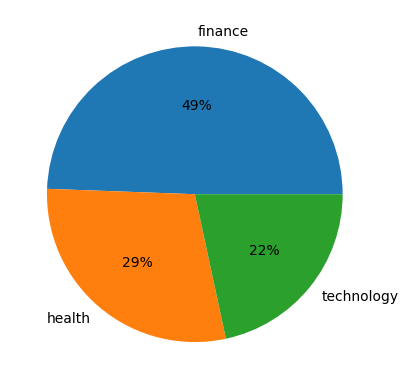

In [146]:
# 0 0 1 -> technology np.argmax = 2
# 0 1 0 -> health np.argmax = 1
# 1 0 0 -> finance np.argmax = 0
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

sector_names = ['finance', 'health', 'technology']
pred_sector_list = np.argmax(materials_pred, axis=1)
sector_pred_list = [sector_names[pred] for pred in pred_sector_list]
sayac = dict(Counter(sector_pred_list))
etiketler = list(sayac.keys())
degerler = list(sayac.values())
plt.pie(degerler, labels=etiketler, autopct='%1.0f%%')
plt.show()

### 4) Materyal sektöründeli şirketlerin yüzde 22'sinin teknoloji alanındaki şirketler ile alakası var. Bu şirketlerin info verilerine göz atalım.

In [147]:
indices = [i for i, sector in enumerate(sector_pred_list) if sector == "technology"]
materials_technology_company = rematerials_ex["Unnamed: 0"][indices].to_list()

In [148]:
for company in materials_technology_company:
  ticker_name = yfinance.Ticker(company)
  print(f"{company} şirketinin info verisi: {ticker_name.info}")

ABAT şirketinin info verisi: {'address1': '100 Washington Street', 'address2': 'Suite 100', 'city': 'Reno', 'state': 'NV', 'zip': '89503', 'country': 'United States', 'phone': '775 473 4744', 'website': 'https://americanbatterytechnology.com', 'industry': 'Other Industrial Metals & Mining', 'industryKey': 'other-industrial-metals-mining', 'industryDisp': 'Other Industrial Metals & Mining', 'sector': 'Basic Materials', 'sectorKey': 'basic-materials', 'sectorDisp': 'Basic Materials', 'longBusinessSummary': 'American Battery Technology Company operates as a battery materials company. The company explores for resources of battery metals, such as such as lithium, nickel, cobalt, and manganese; and develops and commercializes technologies for the extraction of battery metals, as well as commercializes integrated process for the recycling of lithium-ion batteries. The company was formerly known as American Battery Metals Corporation. American Battery Technology Company was incorporated in 201

## e) İletişim hizmetleri sektöründe bulunan butun sembollerin cogunluğu hangi sektore(T,F,H) benzedigi bilgisi için modelimi kullanacağım.

In [149]:
commun = pd.read_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/communication-services.csv').Symbol.to_list()
data_commun = yfinance.download(commun, start='2005-01-01')
data_close_commun=data_commun['Adj Close'].resample('W-MON').last().pct_change()+1
commun_df = data_close_commun
commun_df.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/communCompanies.csv")

[*********************100%%**********************]  260 of 260 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['LGF.A']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [150]:
commun_df = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/communCompanies.csv")
recommun = pd.melt(commun_df, id_vars=["Date"], value_vars=list(commun_df.columns), var_name="Ticker", value_name="Value")

In [151]:
recommun.dropna(inplace=True)

In [152]:
recommun_ex = tsfresh.extract_features(recommun, column_id="Ticker",column_sort="Date", column_value="Value",default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())

Feature Extraction: 100%|██████████| 259/259 [02:32<00:00,  1.70it/s]


In [153]:
recommun_ex

Value__variance_larger_than_standard_deviation  \
ABLV                                             0.0   
ADD                                              0.0   
ADTH                                             0.0   
ADV                                              0.0   
AGAE                                             0.0   
...                                              ...   
YY                                               0.0   
Z                                                0.0   
ZD                                               0.0   
ZDGE                                             0.0   
ZH                                               0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
ABLV                       0.0                       0.0   
ADD                        0.0                       1.0   
ADTH                       0.0                       0.0   
ADV                        0.0                       0.0   
AGAE                       0.0                       0.0   
...                        ...                       ...   
YY                         0.0                       0.0   
Z                          0.0                       0.0   
ZD                         0.0                       0.0   
ZDGE                       0.0                       0.0   
ZH                         0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
ABLV                   0.0          27.316097          28.286790   
ADD                    1.0         800.705887         820.744976   
ADTH                   1.0         150.739817         152.059717   
ADV                    1.0         218.671769         219.446901   
AGAE                   1.0         332.855571         337.490661   
...                    ...                ...                ...   
YY                     0.0         593.245869         600.719048   
Z                      0.0         451.861772         456.321278   
ZD                     1.0        1004.652748        1009.345186   
ZDGE                   1.0         408.143467         415.826359   
ZH                     1.0         153.842729         155.118266   

      Value__mean_abs_change  Value__mean_change  \
ABLV                0.137433           -0.007887   
ADD                 0.144793            0.000284   
ADTH                0.098961            0.001149   
ADV                 0.065788            0.000267   
AGAE                0.088683            0.000006   
...                      ...                 ...   
YY                  0.093962           -0.000352   
Z                   0.076656           -0.000232   
ZD                  0.048442            0.000012   
ZDGE                0.115404           -0.000034   
ZH                  0.133744           -0.000637   

      Value__mean_second_derivative_central  Value__median  ...  \
ABLV                               0.005232       0.984709  ...   
ADD                                0.000239       0.998038  ...   
ADTH                               0.000928       1.000000  ...   
ADV                                0.000111       1.000000  ...   
AGAE                              -0.000051       1.000000  ...   
...                                     ...            ...  ...   
YY                                 0.000488       1.003094  ...   
Z                                 -0.000180       1.003084  ...   
ZD                                -0.000126       1.003637  ...   
ZDGE                               0.000116       0.994287  ...   
ZH                                 0.001093       0.990196  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
ABLV                        1.470132                         1.846889   
ADD                         1.309882                         1.934343   
ADTH                        1.002239                         1.632345   
ADV                         0.930123                         1.573015   


In [154]:
recommun_ex.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/recommun_ex.csv")

### 1) extract edilmiş iletişim sektörü değerlerini vakit kaybetmeden çağırmak için buradan itibaren çalıştırabiliriz.

In [155]:
recommun_ex = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/recommun_ex.csv")

1-) bütün sütunu nan değerler olanları sil  
2-) infinitive değerleri 0 ile değiştir

In [156]:
recommun_ex.dropna(how="all",axis=1,inplace=True)
recommun_ex.replace([np.inf, -np.inf], 0, inplace=True)

 ### 2) Verisetimizin featurlarını değiştirirken modelimiz için kullanmış olduğumuz feature engineering adımlarını pipeline ile yapacağız.

In [157]:
from feature_engine.imputation import MeanMedianImputer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sayisal_degiskenler_commun= recommun_ex.select_dtypes(include=[np.float64, np.int64]).columns

ImputerEngine = MeanMedianImputer(imputation_method="mean",variables=sayisal_degiskenler_commun.to_list())
scaler_std = MinMaxScaler()
outlier_LOF = LocalOutlierFactor(n_neighbors=5)
def remove_outliers(X):
    outlier_mask = outlier_LOF.fit_predict(X) != -1
    return X[outlier_mask], ~outlier_mask

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler_std, sayisal_degiskenler_commun)
    ])

pipeline = Pipeline(steps=[
    ('imputer', ImputerEngine),
    ('scaler', preprocessor),
    ('outlier_remover', FunctionTransformer(remove_outliers)),
])
recommun_ex_dataframe, outliers = pipeline.fit_transform(recommun_ex)

In [158]:
recommun_ex = recommun_ex[~outliers].reset_index(drop=True)
recommun_ex_dataframe = pd.DataFrame(recommun_ex_dataframe, columns=sayisal_degiskenler_commun)

### 3) İletişim sektörü verilerimizi modelimize giriş değişkeni olarak veriyoruz ve İletişim sektörü şirketlerinin teknoloji, sağlık ve finans alanlarından hangisine daha çok benzediğinin değerlendirmesini yapıyoruz.

In [159]:
commun_pred = clf.predict(recommun_ex_dataframe)

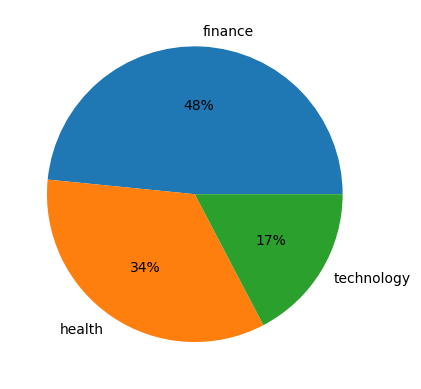

In [160]:
# 0 0 1 -> technology np.argmax = 2
# 0 1 0 -> health np.argmax = 1
# 1 0 0 -> finance np.argmax = 0
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

sector_names = ['finance', 'health', 'technology']
pred_sector_list = np.argmax(commun_pred, axis=1)
sector_pred_list = [sector_names[pred] for pred in pred_sector_list]
sayac = dict(Counter(sector_pred_list))
etiketler = list(sayac.keys())
degerler = list(sayac.values())
plt.pie(degerler, labels=etiketler, autopct='%1.0f%%')
plt.show()

### 4) İletişim sektörü şirketlerin yüzde 17'sinin teknoloji alanındaki şirketler ile alakası var. Bu şirketlerin info verilerine göz atalım.

In [161]:
indices = [i for i, sector in enumerate(sector_pred_list) if sector == "technology"]
commun_technology_company = recommun_ex["Unnamed: 0"][indices].to_list()

In [162]:
for company in commun_technology_company:
  ticker_name = yfinance.Ticker(company)
  print(f"{company} şirketinin info verisi: {ticker_name.info}")

ADV şirketinin info verisi: {'address1': '15310 Barranca Parkway', 'address2': 'Suite 100', 'city': 'Irvine', 'state': 'CA', 'zip': '92618', 'country': 'United States', 'phone': '949 797 2900', 'website': 'https://advantagesolutions.net', 'industry': 'Advertising Agencies', 'industryKey': 'advertising-agencies', 'industryDisp': 'Advertising Agencies', 'sector': 'Communication Services', 'sectorKey': 'communication-services', 'sectorDisp': 'Communication Services', 'longBusinessSummary': 'Advantage Solutions Inc. provides business solutions to consumer goods manufacturers and retailers in North America and internationally. It operates in two segments, Sales and Marketing. The Sales segment offers brand-centric services, such as headquarter relationship management; analytics, insights, and intelligence; and brand-centric merchandising services. This segment also provides retailer-centric services comprising retailer-centric merchandising and in-store media services. The Marketing segment

## f) Enerji sektöründe bulunan butun sembollerin cogunluğu hangi sektore(T,F,H) benzedigi bilgisi için modelimi kullanacağım.




In [163]:
energy = pd.read_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/energy.csv').Symbol.to_list()
data_energy = yfinance.download(energy, start='2005-01-01')
data_close_energy=data_energy['Adj Close'].resample('W-MON').last().pct_change()+1
energy_df = data_close_energy
energy_df.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/energyCompanies.csv")

[*********************100%%**********************]  252 of 252 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['PBR.A']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [164]:
energy_df = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/energyCompanies.csv")
reenergy = pd.melt(energy_df, id_vars=["Date"], value_vars=list(energy_df.columns), var_name="Ticker", value_name="Value")

In [165]:
reenergy.dropna(inplace=True)

In [166]:
reenergy_ex = tsfresh.extract_features(reenergy, column_id="Ticker",column_sort="Date", column_value="Value",default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())

Feature Extraction: 100%|██████████| 251/251 [03:22<00:00,  1.24it/s]


In [167]:
reenergy_ex

Value__variance_larger_than_standard_deviation  \
ACDC                                             0.0   
AE                                               0.0   
AESI                                             0.0   
AM                                               0.0   
AMPY                                             1.0   
...                                              ...   
WTI                                              0.0   
WTTR                                             0.0   
XOM                                              0.0   
XPRO                                             0.0   
YPF                                              0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
ACDC                       0.0                       0.0   
AE                         0.0                       0.0   
AESI                       0.0                       0.0   
AM                         0.0                       0.0   
AMPY                       0.0                       0.0   
...                        ...                       ...   
WTI                        0.0                       0.0   
WTTR                       0.0                       0.0   
XOM                        0.0                       0.0   
XPRO                       0.0                       0.0   
YPF                        0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
ACDC                   1.0          95.470679          95.510022   
AE                     1.0        1005.067832        1012.859664   
AESI                   0.0          53.419036          53.946270   
AM                     1.0         358.947317         361.515154   
AMPY                   1.0         807.975384       36262.600340   
...                    ...                ...                ...   
WTI                    1.0        1000.964451        1013.379662   
WTTR                   1.0         351.916145         355.172432   
XOM                    1.0        1004.041873        1007.288095   
XPRO                   1.0         552.744351         556.024577   
YPF                    1.0        1004.296700        1011.655266   

      Value__mean_abs_change  Value__mean_change  \
ACDC                0.084790            0.000222   
AE                  0.070205           -0.000036   
AESI                0.051843            0.000748   
AM                  0.061790            0.000029   
AMPY                0.730609           -0.000058   
...                      ...                 ...   
WTI                 0.097419            0.000002   
WTTR                0.083256            0.000100   
XOM                 0.035725            0.000023   
XPRO                0.081816            0.000015   
YPF                 0.068235            0.000036   

      Value__mean_second_derivative_central  Value__median  ...  \
ACDC                               0.000203       0.995199  ...   
AE                                -0.000007       1.000324  ...   
AESI                              -0.000555       1.012021  ...   
AM                                -0.000137       1.002735  ...   
AMPY                               0.000155       0.993489  ...   
...                                     ...            ...  ...   
WTI                                0.000031       0.997251  ...   
WTTR                               0.000133       0.998761  ...   
XOM                               -0.000024       1.001821  ...   
XPRO                              -0.000036       0.997955  ...   
YPF                                0.000044       1.000000  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
ACDC                        0.941229                         1.518921   
AE                          1.300552                         1.950501   
AESI                        0.985346                         1.565945   
AM                          0.409490                         0.912481   


In [168]:
reenergy_ex.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/reenergy_ex.csv")

### 1) extract edilmiş enerji sektörü değerlerini vakit kaybetmeden çağırmak için buradan itibaren çalıştırabiliriz.

In [169]:
reenergy_ex = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/reenergy_ex.csv")

1-) bütün sütunu nan değerler olanları sil  
2-) infinitive değerleri 0 ile değiştir

In [170]:
reenergy_ex.dropna(how="all",axis=1,inplace=True)
reenergy_ex.replace([np.inf, -np.inf], 0, inplace=True)

 ### 2) Verisetimizin featurlarını değiştirirken modelimiz için kullanmış olduğumuz feature engineering adımlarını pipeline ile yapacağız.

In [171]:
from feature_engine.imputation import MeanMedianImputer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sayisal_degiskenler_energy= reenergy_ex.select_dtypes(include=[np.float64, np.int64]).columns

ImputerEngine = MeanMedianImputer(imputation_method="mean",variables=sayisal_degiskenler_energy.to_list())
scaler_std = MinMaxScaler()
outlier_LOF = LocalOutlierFactor(n_neighbors=5)
def remove_outliers(X):
    outlier_mask = outlier_LOF.fit_predict(X) != -1
    return X[outlier_mask], ~outlier_mask

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler_std, sayisal_degiskenler_energy)
    ])

pipeline = Pipeline(steps=[
    ('imputer', ImputerEngine),
    ('scaler', preprocessor),
    ('outlier_remover', FunctionTransformer(remove_outliers)),
])
reenergy_ex_dataframe, outliers = pipeline.fit_transform(reenergy_ex)

In [172]:
reenergy_ex = reenergy_ex[~outliers].reset_index(drop=True)
reenergy_ex_dataframe = pd.DataFrame(reenergy_ex_dataframe, columns=sayisal_degiskenler_energy)

### 3) Enerji sektörü verilerimizi modelimize giriş değişkeni olarak veriyoruz ve Enerji sektörü şirketlerinin teknoloji, sağlık ve finans alanlarından hangisine daha çok benzediğinin değerlendirmesini yapıyoruz.

In [173]:
energy_pred = clf.predict(reenergy_ex_dataframe)

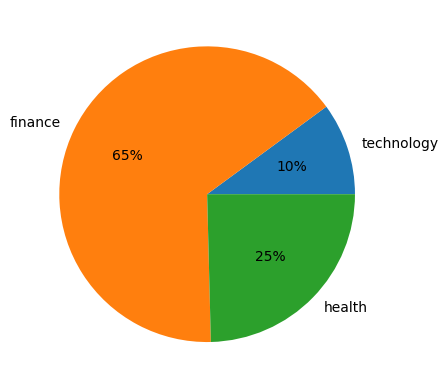

In [174]:
# 0 0 1 -> technology np.argmax = 2
# 0 1 0 -> health np.argmax = 1
# 1 0 0 -> finance np.argmax = 0
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

sector_names = ['finance', 'health', 'technology']
pred_sector_list = np.argmax(energy_pred, axis=1)
sector_pred_list = [sector_names[pred] for pred in pred_sector_list]
sayac = dict(Counter(sector_pred_list))
etiketler = list(sayac.keys())
degerler = list(sayac.values())
plt.pie(degerler, labels=etiketler, autopct='%1.0f%%')
plt.show()

### 4) Enerji sektörü şirketlerin yüzde 10'sinin teknoloji alanındaki şirketler ile alakası var. Bu şirketlerin info verilerine göz atalım.

In [175]:
indices = [i for i, sector in enumerate(sector_pred_list) if sector == "technology"]
energy_technology_company = reenergy_ex["Unnamed: 0"][indices].to_list()

In [176]:
for company in energy_technology_company:
  ticker_name = yfinance.Ticker(company)
  print(f"{company} şirketinin info verisi: {ticker_name.info}")

ACDC şirketinin info verisi: {'address1': '333 Shops Boulevard', 'address2': 'Suite 301', 'city': 'Willow Park', 'state': 'TX', 'zip': '76087', 'country': 'United States', 'phone': '254 776 3722', 'website': 'https://www.pfholdingscorp.com', 'industry': 'Oil & Gas Equipment & Services', 'industryKey': 'oil-gas-equipment-services', 'industryDisp': 'Oil & Gas Equipment & Services', 'sector': 'Energy', 'sectorKey': 'energy', 'sectorDisp': 'Energy', 'longBusinessSummary': 'ProFrac Holding Corp. operates as a technology-focused energy services holding company in the United States. It operates through three segments: Stimulation Services, Manufacturing, and Proppant Production. The company offers hydraulic fracturing, well stimulation, in-basin frac sand, and other completion services and complementary products and services to upstream oil and natural gas companies engaged in the exploration and production of unconventional oil and natural gas resources. It also manufactures and sells high h

## g) Temel Tüketim sektöründe bulunan butun sembollerin cogunluğu hangi sektore(T,F,H) benzedigi bilgisi için modelimi kullanacağım.




In [177]:
staples = pd.read_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/consumer-staples.csv').Symbol.to_list()
data_staples = yfinance.download(staples, start='2005-01-01')
data_close_staples=data_staples['Adj Close'].resample('W-MON').last().pct_change()+1
staples_df = data_close_staples
staples_df.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/staplesCompanies.csv")

[*********************100%%**********************]  241 of 241 completed
ERROR:yfinance:
5 Failed downloads:
ERROR:yfinance:['BF.A', 'AKO.A', 'MKC.V', 'AKO.B', 'TAP.A']: Exception('%ticker%: No timezone found, symbol may be delisted')


In [178]:
staples_df = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/staplesCompanies.csv")
restaples = pd.melt(staples_df, id_vars=["Date"], value_vars=list(staples_df.columns), var_name="Ticker", value_name="Value")

In [179]:
restaples.dropna(inplace=True)

In [180]:
restaples_ex = tsfresh.extract_features(restaples, column_id="Ticker",column_sort="Date", column_value="Value",default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())

Feature Extraction: 100%|██████████| 236/236 [03:34<00:00,  1.10it/s]


In [181]:
restaples_ex

Value__variance_larger_than_standard_deviation  \
AACG                                             0.0   
AAGR                                             0.0   
ABEV                                             0.0   
ACI                                              0.0   
ACU                                              0.0   
...                                              ...   
WVVI                                             0.0   
XXII                                             0.0   
YGF                                              0.0   
YQ                                               0.0   
ZVIA                                             0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
AACG                       0.0                       0.0   
AAGR                       0.0                       0.0   
ABEV                       0.0                       0.0   
ACI                        0.0                       0.0   
ACU                        0.0                       0.0   
...                        ...                       ...   
WVVI                       0.0                       0.0   
XXII                       0.0                       0.0   
YGF                        0.0                       0.0   
YQ                         0.0                       0.0   
ZVIA                       0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
AACG                   1.0         849.258801         885.557453   
AAGR                   1.0         126.322219         128.671338   
ABEV                   1.0        1004.236359        1008.858514   
ACI                    1.0         194.846359         196.096904   
ACU                    1.0        1004.403541        1008.766420   
...                    ...                ...                ...   
WVVI                   1.0        1003.669398        1007.705628   
XXII                   1.0         687.273646         705.052561   
YGF                    1.0          48.864361          48.584944   
YQ                     1.0         168.982138         171.837770   
ZVIA                   0.0         136.515689         136.885847   

      Value__mean_abs_change  Value__mean_change  \
AACG                0.113941            0.000050   
AAGR                0.064277            0.002855   
ABEV                0.051970           -0.000002   
ACI                 0.044584            0.000004   
ACU                 0.046659           -0.000064   
...                      ...                 ...   
WVVI                0.045837           -0.000068   
XXII                0.147496           -0.000165   
YGF                 0.121967            0.003244   
YQ                  0.172672           -0.001846   
ZVIA                0.130772           -0.000838   

      Value__mean_second_derivative_central  Value__median  ...  \
AACG                              -0.000070       0.994975  ...   
AAGR                               0.003480       1.000000  ...   
ABEV                              -0.000028       1.001515  ...   
ACI                                0.000146       1.001423  ...   
ACU                                0.000072       1.000000  ...   
...                                     ...            ...  ...   
WVVI                               0.000017       1.000000  ...   
XXII                               0.000062       0.991851  ...   
YGF                               -0.002228       1.000000  ...   
YQ                                 0.000170       0.981110  ...   
ZVIA                              -0.000316       0.983619  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
AACG                        1.300987                         1.916007   
AAGR                        1.534513                         2.150839   
ABEV                        1.327650                         1.969312   
ACI                         1.266071                         1.929943   


In [182]:
restaples_ex.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/restaples_ex.csv")

### 1) extract edilmiş temel tüketim sektörü değerlerini vakit kaybetmeden çağırmak için buradan itibaren çalıştırabiliriz.

In [183]:
restaples_ex = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/restaples_ex.csv")

1-) bütün sütunu nan değerler olanları sil  
2-) infinitive değerleri 0 ile değiştir

In [184]:
restaples_ex.dropna(how="all",axis=1,inplace=True)
restaples_ex.replace([np.inf, -np.inf], 0, inplace=True)

 ### 2) Verisetimizin featurlarını değiştirirken modelimiz için kullanmış olduğumuz feature engineering adımlarını pipeline ile yapacağız.

In [185]:
from feature_engine.imputation import MeanMedianImputer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sayisal_degiskenler_staples= restaples_ex.select_dtypes(include=[np.float64, np.int64]).columns

ImputerEngine = MeanMedianImputer(imputation_method="mean",variables=sayisal_degiskenler_staples.to_list())
scaler_std = MinMaxScaler()
outlier_LOF = LocalOutlierFactor(n_neighbors=5)
def remove_outliers(X):
    outlier_mask = outlier_LOF.fit_predict(X) != -1
    return X[outlier_mask], ~outlier_mask

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler_std, sayisal_degiskenler_staples)
    ])

pipeline = Pipeline(steps=[
    ('imputer', ImputerEngine),
    ('scaler', preprocessor),
    ('outlier_remover', FunctionTransformer(remove_outliers)),
])
restaples_ex_dataframe, outliers = pipeline.fit_transform(restaples_ex)

In [186]:
restaples_ex = restaples_ex[~outliers].reset_index(drop=True)
restaples_ex_dataframe = pd.DataFrame(restaples_ex_dataframe, columns=sayisal_degiskenler_staples)

### 3) Temel tüketim sektörü verilerimizi modelimize giriş değişkeni olarak veriyoruz ve Temel tüketim sektörü şirketlerinin teknoloji, sağlık ve finans alanlarından hangisine daha çok benzediğinin değerlendirmesini yapıyoruz.

In [187]:
staples_pred = clf.predict(restaples_ex_dataframe)

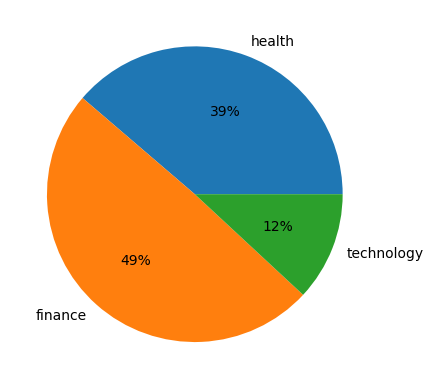

In [188]:
# 0 0 1 -> technology np.argmax = 2
# 0 1 0 -> health np.argmax = 1
# 1 0 0 -> finance np.argmax = 0
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

sector_names = ['finance', 'health', 'technology']
pred_sector_list = np.argmax(staples_pred, axis=1)
sector_pred_list = [sector_names[pred] for pred in pred_sector_list]
sayac = dict(Counter(sector_pred_list))
etiketler = list(sayac.keys())
degerler = list(sayac.values())
plt.pie(degerler, labels=etiketler, autopct='%1.0f%%')
plt.show()

### 4) Temel tüketim sektörü şirketlerin yüzde 12'sinin teknoloji alanındaki şirketler ile alakası var. Bu şirketlerin info verilerine göz atalım.

In [189]:
indices = [i for i, sector in enumerate(sector_pred_list) if sector == "technology"]
staples_technology_company = restaples_ex["Unnamed: 0"][indices].to_list()

In [190]:
for company in staples_technology_company:
  ticker_name = yfinance.Ticker(company)
  print(f"{company} şirketinin info verisi: {ticker_name.info}")

AGRI şirketinin info verisi: {'address1': '2233 Columbia Street', 'address2': 'Suite 300 3rd Floor', 'city': 'Vancouver', 'state': 'BC', 'zip': 'V5Y 0M6', 'country': 'Canada', 'phone': '604 757 0952', 'website': 'https://agriforcegs.com', 'industry': 'Farm Products', 'industryKey': 'farm-products', 'industryDisp': 'Farm Products', 'sector': 'Consumer Defensive', 'sectorKey': 'consumer-defensive', 'sectorDisp': 'Consumer Defensive', 'longBusinessSummary': 'AgriFORCE Growing Systems Ltd., an agriculture-focused technology company, focuses on the development and commercialization of plant-based ingredients and products that deliver healthier and nutritious solutions. The company operates in two divisions, AgriFORCE Solutions and AgriFORCE Brands. It also offers management advisory services and holds intellectual property, as well as engages in the real estate holding and development activities. The company was formerly known as Canivate Growing Systems Ltd. and changed its name to AgriFOR

## h) Kamu hizmetleri sektöründe bulunan butun sembollerin cogunluğu hangi sektore(T,F,H) benzedigi bilgisi için modelimi kullanacağım.




In [191]:
utilities = pd.read_csv('/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/stock_sectors/utilities.csv').Symbol.to_list()
data_utilities = yfinance.download(utilities, start='2005-01-01')
data_close_utilities=data_utilities['Adj Close'].resample('W-MON').last().pct_change()+1
utilities_df = data_close_utilities
utilities_df.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/utilitiesCompanies.csv")

[*********************100%%**********************]  108 of 108 completed


In [192]:
utilities_df = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/best_of_sectors_company/utilitiesCompanies.csv")
reutilities = pd.melt(utilities_df, id_vars=["Date"], value_vars=list(utilities_df.columns), var_name="Ticker", value_name="Value")

In [193]:
reutilities.dropna(inplace=True)

In [194]:
reutilities_ex = tsfresh.extract_features(reutilities, column_id="Ticker",column_sort="Date", column_value="Value",default_fc_parameters=tsfresh.feature_extraction.ComprehensiveFCParameters())

Feature Extraction: 100%|██████████| 108/108 [02:32<00:00,  1.41s/it]


In [195]:
reutilities_ex

Value__variance_larger_than_standard_deviation  \
ADN                                              0.0   
AEE                                              0.0   
AEP                                              0.0   
AES                                              0.0   
AGR                                              0.0   
...                                              ...   
WAVE                                             0.0   
WEC                                              0.0   
WTRG                                             0.0   
XEL                                              0.0   
YORW                                             0.0   

      Value__has_duplicate_max  Value__has_duplicate_min  \
ADN                        0.0                       0.0   
AEE                        0.0                       0.0   
AEP                        0.0                       0.0   
AES                        0.0                       0.0   
AGR                        0.0                       0.0   
...                        ...                       ...   
WAVE                       0.0                       0.0   
WEC                        0.0                       0.0   
WTRG                       0.0                       0.0   
XEL                        0.0                       0.0   
YORW                       0.0                       0.0   

      Value__has_duplicate  Value__sum_values  Value__abs_energy  \
ADN                    1.0         265.658919         267.231670   
AEE                    1.0        1003.607474        1006.071475   
AEP                    0.0        1004.024643        1006.808768   
AES                    1.0        1003.639646        1007.640430   
AGR                    0.0         430.625126         431.748141   
...                    ...                ...                ...   
WAVE                   1.0         139.203789         139.196512   
WEC                    1.0        1004.516826        1007.765224   
WTRG                   1.0        1003.943954        1007.009094   
XEL                    1.0        1004.111392        1006.893173   
YORW                   1.0        1004.085076        1007.409489   

      Value__mean_abs_change  Value__mean_change  \
ADN                 0.092422           -0.000713   
AEE                 0.030088           -0.000021   
AEP                 0.028590           -0.000003   
AES                 0.049016           -0.000052   
AGR                 0.034392           -0.000185   
...                      ...                 ...   
WAVE                0.118708            0.002019   
WEC                 0.027076           -0.000026   
WTRG                0.034495            0.000005   
XEL                 0.026647            0.000013   
YORW                0.037243            0.000066   

      Value__mean_second_derivative_central  Value__median  ...  \
ADN                               -0.000470       0.999021  ...   
AEE                               -0.000018       1.002486  ...   
AEP                               -0.000027       1.003226  ...   
AES                               -0.000080       1.002273  ...   
AGR                               -0.000066       1.001498  ...   
...                                     ...            ...  ...   
WAVE                              -0.000704       0.986207  ...   
WEC                               -0.000020       1.003525  ...   
WTRG                              -0.000009       1.003260  ...   
XEL                               -0.000040       1.003129  ...   
YORW                              -0.000075       1.001511  ...   

      Value__fourier_entropy__bins_5  Value__fourier_entropy__bins_10  \
ADN                         1.352070                         2.025123   
AEE                         1.347238                         2.001033   
AEP                         1.279447                         1.934876   
AES                         1.172600                         1.747880   


In [196]:
reutilities_ex.to_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/reutilities_ex.csv")

### 1) extract edilmiş Kamu hizmetleri sektörü değerlerini vakit kaybetmeden çağırmak için buradan itibaren çalıştırabiliriz.

In [197]:
reutilities_ex = pd.read_csv("/content/drive/MyDrive/Veri-Yogun-Uygulamalar-Proje/data/extract_feature_dataset/reutilities_ex.csv")

1-) bütün sütunu nan değerler olanları sil  
2-) infinitive değerleri 0 ile değiştir

In [198]:
reutilities_ex.dropna(how="all",axis=1,inplace=True)
reutilities_ex.replace([np.inf, -np.inf], 0, inplace=True)

 ### 2) Verisetimizin featurlarını değiştirirken modelimiz için kullanmış olduğumuz feature engineering adımlarını pipeline ile yapacağız.

In [199]:
from feature_engine.imputation import MeanMedianImputer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

sayisal_degiskenler_utilities= reutilities_ex.select_dtypes(include=[np.float64, np.int64]).columns

ImputerEngine = MeanMedianImputer(imputation_method="mean",variables=sayisal_degiskenler_utilities.to_list())
scaler_std = MinMaxScaler()
outlier_LOF = LocalOutlierFactor(n_neighbors=5)
def remove_outliers(X):
    outlier_mask = outlier_LOF.fit_predict(X) != -1
    return X[outlier_mask], ~outlier_mask

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler_std, sayisal_degiskenler_utilities)
    ])

pipeline = Pipeline(steps=[
    ('imputer', ImputerEngine),
    ('scaler', preprocessor),
    ('outlier_remover', FunctionTransformer(remove_outliers)),
])
reutilities_ex_dataframe, outliers = pipeline.fit_transform(reutilities_ex)

In [200]:
reutilities_ex = reutilities_ex[~outliers].reset_index(drop=True)
reutilities_ex_dataframe = pd.DataFrame(reutilities_ex_dataframe, columns=sayisal_degiskenler_utilities)

### 3) Kamu hizmetleri sektörü verilerimizi modelimize giriş değişkeni olarak veriyoruz ve Kamu hizmetleri sektörü şirketlerinin teknoloji, sağlık ve finans alanlarından hangisine daha çok benzediğinin değerlendirmesini yapıyoruz.

In [201]:
utilities_pred = clf.predict(reutilities_ex_dataframe)

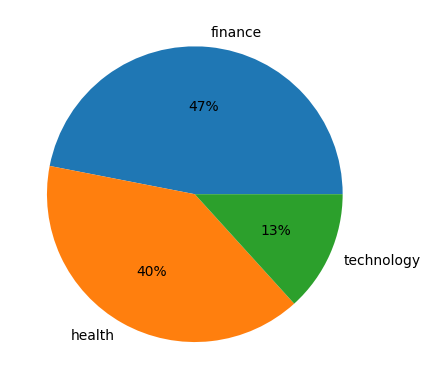

In [202]:
# 0 0 1 -> technology np.argmax = 2
# 0 1 0 -> health np.argmax = 1
# 1 0 0 -> finance np.argmax = 0
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

sector_names = ['finance', 'health', 'technology']
pred_sector_list = np.argmax(utilities_pred, axis=1)
sector_pred_list = [sector_names[pred] for pred in pred_sector_list]
sayac = dict(Counter(sector_pred_list))
etiketler = list(sayac.keys())
degerler = list(sayac.values())
plt.pie(degerler, labels=etiketler, autopct='%1.0f%%')
plt.show()

### 4) Kamu hizmetleri sektörü şirketlerin yüzde 12'sinin teknoloji alanındaki şirketler ile alakası var. Bu şirketlerin info verilerine göz atalım.

In [203]:
indices = [i for i, sector in enumerate(sector_pred_list) if sector == "technology"]
utilities_technology_company = reutilities_ex["Unnamed: 0"][indices].to_list()

In [204]:
for company in utilities_technology_company:
  ticker_name = yfinance.Ticker(company)
  print(f"{company} şirketinin info verisi: {ticker_name.info}")

ARIS şirketinin info verisi: {'address1': '9651 Katy Freeway', 'address2': 'Suite 400', 'city': 'Houston', 'state': 'TX', 'zip': '77024', 'country': 'United States', 'phone': '281 304 7003', 'website': 'https://www.ariswater.com', 'industry': 'Utilities - Regulated Water', 'industryKey': 'utilities-regulated-water', 'industryDisp': 'Utilities - Regulated Water', 'sector': 'Utilities', 'sectorKey': 'utilities', 'sectorDisp': 'Utilities', 'longBusinessSummary': "Aris Water Solutions, Inc., an environmental infrastructure and solutions company, provides water handling and recycling solutions. The company's produced water handling business gathers, transports, unless recycled, and handles produced water generated from oil and natural gas production. Its water solutions business develops and operates recycling facilities to treat, store, and recycle produced water. Aris Water Solutions, Inc. was founded in 2015 and is headquartered in Houston, Texas.", 'fullTimeEmployees': 251, 'companyOffi